# function prepare

## main

In [130]:
plot_highest_exprs <- function(mat_filter_path=mat_filter_path, top_n = 20,png_out_path='png/'){
    library(magrittr)
    mat <- read.table(mat_filter_path,sep='\t',header=TRUE,check.names = FALSE)
    #name<-c()
    #for(i in seq_len(length(rownames(mat)))){
    #    name[i] <- paste(unlist(strsplit(rownames(mat)[i],"|",fixed=T))[1],unlist(strsplit(rownames(mat)[i],"|",fixed=T))[2],unlist(strsplit(rownames(mat)[i],"|",fixed=T))[3],unlist(strsplit(rownames(mat)[i],"|",fixed=T))[6],unlist(strsplit(rownames(mat)[i],"|",fixed=T))[7],sep='|')
    #}
    #row.names(mat)<- name
    object <- mat %>% as_SingleCellExperiment() %>% {suppressMessages(scater::calculateQCMetrics(.))}
    rdata <- SingleCellExperiment::rowData(object)
    oo <- order(rdata[["rank_counts"]], decreasing = TRUE)
    name<-c()
    for(i in seq_len(length(rownames(mat)))){
        if(i %in% oo[1:top_n])
            name[i] <- unlist(strsplit(rownames(mat)[i],"|",fixed=T))[1] #name
        else
            name[i] <- rownames(mat)[i]
    }
    row.names(mat)<- name
    mat %>% as_SingleCellExperiment() %>% {suppressMessages(scater::calculateQCMetrics(.))} %>% scater::plotHighestExprs(n = top_n)
}


In [124]:
row.names(mat[oo[1:20], ])<-unlist(strsplit(rownames(mat[oo[1:20], ]),"|",fixed=T))[3]

ERROR: Error in `row.names<-.data.frame`(`*tmp*`, value = "hsa_piR_020326"): invalid 'row.names' length


In [125]:
row.names(mat[1,])<- 1
rownames(mat[1,])

[1] "hsa-let-7a-1|miRNA|hsa-let-7a-1|hsa-let-7a-1|hsa-let-7a-1|0|80"

In [2]:
count_depth_norm <- function(mat_list=c("Norm_CPM","Norm_CPM_rm","Norm_CPM_top","Norm_null",
                                        "Norm_RLE","Norm_SCnorm","Norm_TMM"),
                             pdf_out_path='pdf/',
                             file_path = "./"){
    allmat=c("Norm_CPM","Norm_CPM_rm","Norm_CPM_top","Norm_null",
             "Norm_RLE","Norm_SCnorm","Norm_TMM")
    library(SCnorm)
    mat_unnorm=read.table(paste(file_path,"scimpute_count.txt",sep=""),header=TRUE,check.names = FALSE)
    par(mfrow=c(2,4))
    for(i in mat_list){
        if(!(i %in% allmat)){
            warning(paste('Check input: ',i,'\tThis normlized matrix is not found\n'))
            next
        }
        #title(main = i)
        mat=read.table(paste(file_path,"filter.null.",i,".domains_combined.txt",sep=""),header=TRUE,check.names = FALSE)
        Conditions = rep(c(1), each= dim(mat)[2])
        countDeptEst <- plotCountDepth(Data = as.matrix(mat_unnorm), NormalizedData = as.matrix(mat), Conditions = Conditions,
                                       FilterCellProportion = .1, NCores=3)
    }
}


In [3]:
count_depth_unnorm <- function(mat_list='mat_impute',
                               pdf_out_path='pdf/',
                               file_path = "./"){
    allmat='mat_impute'
    library(SCnorm)
    resfactor = 3
    for(i in mat_list){
        if(!(i %in% allmat)){
            warning(paste('Check input: ',i,'\tThis matrix is not found\n'))
            next
        }
        mat=read.table(paste(file_path,"scimpute_count.txt",sep=""))
        #png(paste(pdf_out_path,i,'_count_depth.png',sep=''),res = 72*resfactor, height=640*resfactor, width=640*resfactor)
        Conditions = rep(c(1), each= dim(mat)[2])
        countDeptEst <- plotCountDepth(Data = mat, Conditions = Conditions,
                                       FilterCellProportion = .1, NCores=3)
        #dev.off()
    }
}

In [4]:
RLE_plot <- function(mat_list=c("Norm_CPM","Norm_CPM_rm","Norm_CPM_top","Norm_null",
                                "Norm_RLE","Norm_SCnorm","Norm_TMM"),
                     impute_method=c("scimpute_count","viper_count","null"),
                     pdf_out_path=".",
                     file_path="."){
    impute_method <- match.arg(impute_method)
    for(i in mat_list)
        assign(i,read.table(paste(file_path,"filter.",impute_method,".",i,".domains_combined.txt",sep=""),header=TRUE))
    reads <- SingleCellExperiment::SingleCellExperiment(
        assays = list(
                      Norm_CPM = as.matrix(Norm_CPM),
                      Norm_CPM_rm = as.matrix(Norm_CPM_rm),
                      Norm_CPM_top = as.matrix(Norm_CPM_top),
                      Norm_RLE = as.matrix(Norm_RLE),
                      Norm_SCnorm = as.matrix(Norm_SCnorm),
                      Norm_TMM = as.matrix(Norm_TMM)))
    res <- list()
    for(n in SummarizedExperiment::assayNames(reads)) {
        res[[n]] <- suppressWarnings(scRNA.seq.funcs::calc_cell_RLE(SummarizedExperiment::assay(reads, n)))
    }
    resfactor = 3 
    par(mar=c(6,4,1,1))
    boxplot(res, las=2,main=paste("RLE of each process after imputation ",impute_method,sep=""),ylab="relative log expression",cex.axis=0.7)
}

In [5]:
plot_cv_density <- function(cv_mat_path=".", 
                            refer_gene_id_path = ".") {
    refer_gene_id <- read.table(refer_gene_id_path)[,1]
    #refer_gene_name <- read.table(refer_gene_name_path)[,1]
    mat=read.table(cv_mat_path,head=TRUE,check.names = FALSE)
    cv <- mat %>% apply(1, cv_fun) %>%
    {tibble::tibble(id = names(.), value = .)} %>%
    dplyr::mutate(id = stringr::str_extract(id, '[^|]+'))
    plot <- ggplot2::ggplot(cv, ggplot2::aes(value)) +
    ggplot2::geom_density(color = '#5F7AB3') +
    ggplot2::labs(x = 'coefficient of variation')
    refer_gene_name<-c()
    if (length(refer_gene_id) != length(refer_gene_name)) {
        warning("Ignoring refer_gene_name, since it isn't the same length as refer_gene_id")
        refer_gene_name = refer_gene_id
    }
    cv_refer <- tibble::tibble(id = refer_gene_id, name = refer_gene_name) %>%
    dplyr::inner_join(cv, by = 'id')
    if (nrow(cv_refer) == 0L) {
        warning("None refer gene found in the count matrix")
        return(plot)
    }
    
    plot + ggplot2::geom_vline(xintercept = cv_refer$value, color = '#93C991') +
    ggplot2::geom_point(
    ggplot2::aes(x = value, y = seq_y(plot, value)),
    data = cv_refer, size = 2, shape = 1
    ) +
    ggrepel::geom_label_repel(
    ggplot2::aes(x = value, y = seq_y(plot, value), label = name),
    data = cv_refer, hjust = 0.5
    )
}

In [6]:
anno_contri_var <-function(mat_path=".",
                           batchinfo_path = ".",
                           classinfo_path = "."
                          ){
    mat <- read.table(mat_path,header=TRUE,check.names = FALSE)
    batch_info <- read.csv(batchinfo_path,sep='\t')
    sample_info <-read.csv(classinfo_path,sep='\t')
    names(batch_info)[1]<-"sample_id"
    names(sample_info)[1]<-"sample_id"
    anno_info <- merge(sample_info,batch_info,by='sample_id',all=T)
    rownames(anno_info)=anno_info$sample_id
    anno_info <- anno_info[names(mat),]
    rownames(anno_info) <-c()

    anno_info$class <- 0
    for(i in seq_len(length(table(anno_info$label)))){
        anno_info[which(anno_info$label==names(table(anno_info$label))[i]),]$class <- i
    }
    
    reads <- SingleCellExperiment::SingleCellExperiment(
        assays = list(counts = as.matrix(mat)),
        colData = anno_info
    )
    reads <-  scater::calculateQCMetrics(reads)
    resfactor =3
    for(n in SummarizedExperiment::assayNames(reads)) {
        print(
            scater::plotQC(
                reads,
                type = "expl",
                exprs_values = n,
                variables = c(
                    "total_features",
                    "total_counts",
                    "class",
                    'RNA.Isolation.batch',
                    'library.prepration.day',
                    'gel.cut.size.selection'
                )
            ) +
            ggplot2::ggtitle(n)
        )
    }
}

## utility

In [7]:
seq_y <- function(plot, x) {
    y_range <- get_y_range(plot)
    by <- diff(y_range) / length(x)
    seq(y_range[1] + by, y_range[2], by) - by/2
}

In [8]:
get_y_range <-
function(plot) {
    ggplot2::ggplot_build(plot)$layout$panel_params[[1]]$y.range
}

In [9]:
cv_fun <- function(x) {
    sd(x, na.rm = T) / mean(x, na.rm = T)
}

In [10]:
as_SingleCellExperiment = function(mat, col_data = NULL) {
    assays = list(counts = as.matrix(mat))
    if (is.null(col_data))
    SingleCellExperiment::SingleCellExperiment(assays = assays)
    else
    SingleCellExperiment::SingleCellExperiment(assays = assays, colData = col_data)
    }


# plot

## prepare

In [28]:
#mat_filter_path='/home/shibinbin/projects/exSeek-dev/output/exorbase/matrix_processing/filter.null.featurecounts.txt'
mat_filter_path = "/home/shibinbin/projects/exSeek-dev/output/scirep/matrix_processing/filter.null.domains_combined.txt"
file_path = "/home/shibinbin/projects/exSeek-dev/output/scirep/matrix_processing/"
mat_list = c("Norm_CPM","Norm_CPM_refer","Norm_CPM_rm","Norm_CPM_top","Norm_RLE","Norm_SCnorm","Norm_TMM")
batchinfo_path= "/home/shibinbin/projects/exSeek-dev/data/scirep/batch_info.txt"
classinfo_path = "/home/shibinbin/projects/exSeek-dev/data/scirep/sample_classes.txt"
refer_gene_id_path ="/home/shibinbin/projects/exSeek-dev/data/scirep/reference_genes.txt"
## plot cv using SCnorm mx
cv_mat_path = "/home/shibinbin/projects/exSeek-dev/output/scirep/matrix_processing/filter.scimpute_count.Norm_SCnorm.domains_combined.txt"


## plot_highest_exprs

In [109]:
object <- mat %>% as_SingleCellExperiment() %>% {
    suppressMessages(scater::calculateQCMetrics(.))
} 
rdata <- SingleCellExperiment::rowData(object)
oo <- order(rdata[["rank_counts"]], decreasing = TRUE)
rownames(SummarizedExperiment::assay(object,"counts")[oo[1:20], ])

[1] "hsa_piR_020326|piRNA|hsa_piR_020326|hsa_piR_020326|hsa_piR_020326|0|31" 
 [2] "hsa_piR_000765|piRNA|hsa_piR_000765|hsa_piR_000765|hsa_piR_000765|0|31" 
 [3] "hsa_piR_004153|piRNA|hsa_piR_004153|hsa_piR_004153|hsa_piR_004153|0|32" 
 [4] "hsa-mir-99a|miRNA|hsa-mir-99a|hsa-mir-99a|hsa-mir-99a|0|81"             
 [5] "hsa_piR_020829|piRNA|hsa_piR_020829|hsa_piR_020829|hsa_piR_020829|0|32" 
 [6] "hsa-mir-22|miRNA|hsa-mir-22|hsa-mir-22|hsa-mir-22|0|85"                 
 [7] "hsa-mir-320a|miRNA|hsa-mir-320a|hsa-mir-320a|hsa-mir-320a|0|72"         
 [8] "hsa_piR_017716|piRNA|hsa_piR_017716|hsa_piR_017716|hsa_piR_017716|0|31" 
 [9] "hsa-mir-100|miRNA|hsa-mir-100|hsa-mir-100|hsa-mir-100|0|80"             
[10] "hsa-let-7i|miRNA|hsa-let-7i|hsa-let-7i|hsa-let-7i|0|84"                 
[11] "ENSG00000201778.1|Y_RNA|Y_RNA|peak_632|ENST00000364908.1|0|40"          
[12] "hsa-mir-128-2|miRNA|hsa-mir-128-2|hsa-mir-128-2|hsa-mir-128-2|0|84"     
[13] "hsa-mir-128-1|miRNA|hsa-mir-128-1|hsa-mir-128-1|hsa-mir-128-1|0|82"     
[14] "hsa-mir-129-2|miRNA|hsa-mir-129-2|hsa-mir-129-2|hsa-mir-129-2|0|90"     
[15] "hsa-mir-129-1|miRNA|hsa-mir-129-1|hsa-mir-129-1|hsa-mir-129-1|0|72"     
[16] "hsa-mir-181a-1|miRNA|hsa-mir-181a-1|hsa-mir-181a-1|hsa-mir-181a-1|0|110"
[17] "hsa-mir-9-1|miRNA|hsa-mir-9-1|hsa-mir-9-1|hsa-mir-9-1|0|89"             
[18] "hsa-mir-9-2|miRNA|hsa-mir-9-2|hsa-mir-9-2|hsa-mir-9-2|0|87"             
[19] "hsa-mir-9-3|miRNA|hsa-mir-9-3|hsa-mir-9-3|hsa-mir-9-3|0|90"             
[20] "hsa-let-7b|miRNA|hsa-let-7b|hsa-let-7b|hsa-let-7b|0|83"

In [120]:
mat[oo[1:20], ]

Sample_1S3
hsa_piR_020326|piRNA|hsa_piR_020326|hsa_piR_020326|hsa_piR_020326|0|31  518575    
hsa_piR_000765|piRNA|hsa_piR_000765|hsa_piR_000765|hsa_piR_000765|0|31  508172    
hsa_piR_004153|piRNA|hsa_piR_004153|hsa_piR_004153|hsa_piR_004153|0|32  581608    
hsa-mir-99a|miRNA|hsa-mir-99a|hsa-mir-99a|hsa-mir-99a|0|81              362369    
hsa_piR_020829|piRNA|hsa_piR_020829|hsa_piR_020829|hsa_piR_020829|0|32  113388    
hsa-mir-22|miRNA|hsa-mir-22|hsa-mir-22|hsa-mir-22|0|85                  169394    
hsa-mir-320a|miRNA|hsa-mir-320a|hsa-mir-320a|hsa-mir-320a|0|72          161999    
hsa_piR_017716|piRNA|hsa_piR_017716|hsa_piR_017716|hsa_piR_017716|0|31   96968    
hsa-mir-100|miRNA|hsa-mir-100|hsa-mir-100|hsa-mir-100|0|80              125313    
hsa-let-7i|miRNA|hsa-let-7i|hsa-let-7i|hsa-let-7i|0|84                   80456    
ENSG00000201778.1|Y_RNA|Y_RNA|peak_632|ENST00000364908.1|0|40            68358    
hsa-mir-128-2|miRNA|hsa-mir-128-2|hsa-mir-128-2|hsa-mir-128-2|0|84       68862    
hsa-mir-128-1|miRNA|hsa-mir-128-1|hsa-mir-128-1|hsa-mir-128-1|0|82       63571    
hsa-mir-129-2|miRNA|hsa-mir-129-2|hsa-mir-129-2|hsa-mir-129-2|0|90       94078    
hsa-mir-129-1|miRNA|hsa-mir-129-1|hsa-mir-129-1|hsa-mir-129-1|0|72       79996    
hsa-mir-181a-1|miRNA|hsa-mir-181a-1|hsa-mir-181a-1|hsa-mir-181a-1|0|110  76997    
hsa-mir-9-1|miRNA|hsa-mir-9-1|hsa-mir-9-1|hsa-mir-9-1|0|89               40819    
hsa-mir-9-2|miRNA|hsa-mir-9-2|hsa-mir-9-2|hsa-mir-9-2|0|87               40747    
hsa-mir-9-3|miRNA|hsa-mir-9-3|hsa-mir-9-3|hsa-mir-9-3|0|90               40543    
hsa-let-7b|miRNA|hsa-let-7b|hsa-let-7b|hsa-let-7b|0|83                   56799    
                                                                        Sample_1S6
hsa_piR_020326|piRNA|hsa_piR_020326|hsa_piR_020326|hsa_piR_020326|0|31  539831    
hsa_piR_000765|piRNA|hsa_piR_000765|hsa_piR_000765|hsa_piR_000765|0|31  530678    
hsa_piR_004153|piRNA|hsa_piR_004153|hsa_piR_004153|hsa_piR_004153|0|32  614897    
hsa-mir-99a|miRNA|hsa-mir-99a|hsa-mir-99a|hsa-mir-99a|0|81              360897    
hsa_piR_020829|piRNA|hsa_piR_020829|hsa_piR_020829|hsa_piR_020829|0|32  178726    
hsa-mir-22|miRNA|hsa-mir-22|hsa-mir-22|hsa-mir-22|0|85                   94751    
hsa-mir-320a|miRNA|hsa-mir-320a|hsa-mir-320a|hsa-mir-320a|0|72           77817    
hsa_piR_017716|piRNA|hsa_piR_017716|hsa_piR_017716|hsa_piR_017716|0|31  110421    
hsa-mir-100|miRNA|hsa-mir-100|hsa-mir-100|hsa-mir-100|0|80              106045    
hsa-let-7i|miRNA|hsa-let-7i|hsa-let-7i|hsa-let-7i|0|84                   72218    
ENSG00000201778.1|Y_RNA|Y_RNA|peak_632|ENST00000364908.1|0|40           102266    
hsa-mir-128-2|miRNA|hsa-mir-128-2|hsa-mir-128-2|hsa-mir-128-2|0|84      114125    
hsa-mir-128-1|miRNA|hsa-mir-128-1|hsa-mir-128-1|hsa-mir-128-1|0|82      107594    
hsa-mir-129-2|miRNA|hsa-mir-129-2|hsa-mir-129-2|hsa-mir-129-2|0|90       62202    
hsa-mir-129-1|miRNA|hsa-mir-129-1|hsa-mir-129-1|hsa-mir-129-1|0|72       52929    
hsa-mir-181a-1|miRNA|hsa-mir-181a-1|hsa-mir-181a-1|hsa-mir-181a-1|0|110  57383    
hsa-mir-9-1|miRNA|hsa-mir-9-1|hsa-mir-9-1|hsa-mir-9-1|0|89               58441    
hsa-mir-9-2|miRNA|hsa-mir-9-2|hsa-mir-9-2|hsa-mir-9-2|0|87               57903    
hsa-mir-9-3|miRNA|hsa-mir-9-3|hsa-mir-9-3|hsa-mir-9-3|0|90               58296    
hsa-let-7b|miRNA|hsa-let-7b|hsa-let-7b|hsa-let-7b|0|83                   56294    
                                                                        Sample_1S9
hsa_piR_020326|piRNA|hsa_piR_020326|hsa_piR_020326|hsa_piR_020326|0|31  520069    
hsa_piR_000765|piRNA|hsa_piR_000765|hsa_piR_000765|hsa_piR_000765|0|31  508233    
hsa_piR_004153|piRNA|hsa_piR_004153|hsa_piR_004153|hsa_piR_004153|0|32  522420    
hsa-mir-99a|miRNA|hsa-mir-99a|hsa-mir-99a|hsa-mir-99a|0|81              311769    
hsa_piR_020829|piRNA|hsa_piR_020829|hsa_piR_020829|hsa_piR_020829|0|32  113338    
hsa-mir-22|miRNA|hsa-mir-22|hsa-mir-22|hsa-mir-22|0|85                  140613    
hsa-m

In [116]:
rownames(SummarizedExperiment::assay(object, "counts")[oo[1:20], ])[1]<-1

In [117]:
rownames(SummarizedExperiment::assay(object, "counts")[oo[1:20], ])[1]

[1] "hsa_piR_020326|piRNA|hsa_piR_020326|hsa_piR_020326|hsa_piR_020326|0|31"

In [119]:
for (i in 20) {
    row.names(SummarizedExperiment::assay(object, "counts")[oo[1:20], ])[i] <- unlist(strsplit(rownames(SummarizedExperiment::assay(object, 
        "counts")[oo[1:20], ])[i], "|", fixed = T))[3]
}
rownames(SummarizedExperiment::assay(object, "counts")[oo[1:20], ])

[1] "hsa_piR_020326|piRNA|hsa_piR_020326|hsa_piR_020326|hsa_piR_020326|0|31" 
 [2] "hsa_piR_000765|piRNA|hsa_piR_000765|hsa_piR_000765|hsa_piR_000765|0|31" 
 [3] "hsa_piR_004153|piRNA|hsa_piR_004153|hsa_piR_004153|hsa_piR_004153|0|32" 
 [4] "hsa-mir-99a|miRNA|hsa-mir-99a|hsa-mir-99a|hsa-mir-99a|0|81"             
 [5] "hsa_piR_020829|piRNA|hsa_piR_020829|hsa_piR_020829|hsa_piR_020829|0|32" 
 [6] "hsa-mir-22|miRNA|hsa-mir-22|hsa-mir-22|hsa-mir-22|0|85"                 
 [7] "hsa-mir-320a|miRNA|hsa-mir-320a|hsa-mir-320a|hsa-mir-320a|0|72"         
 [8] "hsa_piR_017716|piRNA|hsa_piR_017716|hsa_piR_017716|hsa_piR_017716|0|31" 
 [9] "hsa-mir-100|miRNA|hsa-mir-100|hsa-mir-100|hsa-mir-100|0|80"             
[10] "hsa-let-7i|miRNA|hsa-let-7i|hsa-let-7i|hsa-let-7i|0|84"                 
[11] "ENSG00000201778.1|Y_RNA|Y_RNA|peak_632|ENST00000364908.1|0|40"          
[12] "hsa-mir-128-2|miRNA|hsa-mir-128-2|hsa-mir-128-2|hsa-mir-128-2|0|84"     
[13] "hsa-mir-128-1|miRNA|hsa-mir-128-1|hsa-mir-128-1|hsa-mir-128-1|0|82"     
[14] "hsa-mir-129-2|miRNA|hsa-mir-129-2|hsa-mir-129-2|hsa-mir-129-2|0|90"     
[15] "hsa-mir-129-1|miRNA|hsa-mir-129-1|hsa-mir-129-1|hsa-mir-129-1|0|72"     
[16] "hsa-mir-181a-1|miRNA|hsa-mir-181a-1|hsa-mir-181a-1|hsa-mir-181a-1|0|110"
[17] "hsa-mir-9-1|miRNA|hsa-mir-9-1|hsa-mir-9-1|hsa-mir-9-1|0|89"             
[18] "hsa-mir-9-2|miRNA|hsa-mir-9-2|hsa-mir-9-2|hsa-mir-9-2|0|87"             
[19] "hsa-mir-9-3|miRNA|hsa-mir-9-3|hsa-mir-9-3|hsa-mir-9-3|0|90"             
[20] "hsa-let-7b|miRNA|hsa-let-7b|hsa-let-7b|hsa-let-7b|0|83"

In [ ]:
rownames(SummarizedExperiment::assay(object,"counts")[oo[1:20], ])<-unlist(strsplit(rownames(mat)[i],"|",fixed=T))[1]

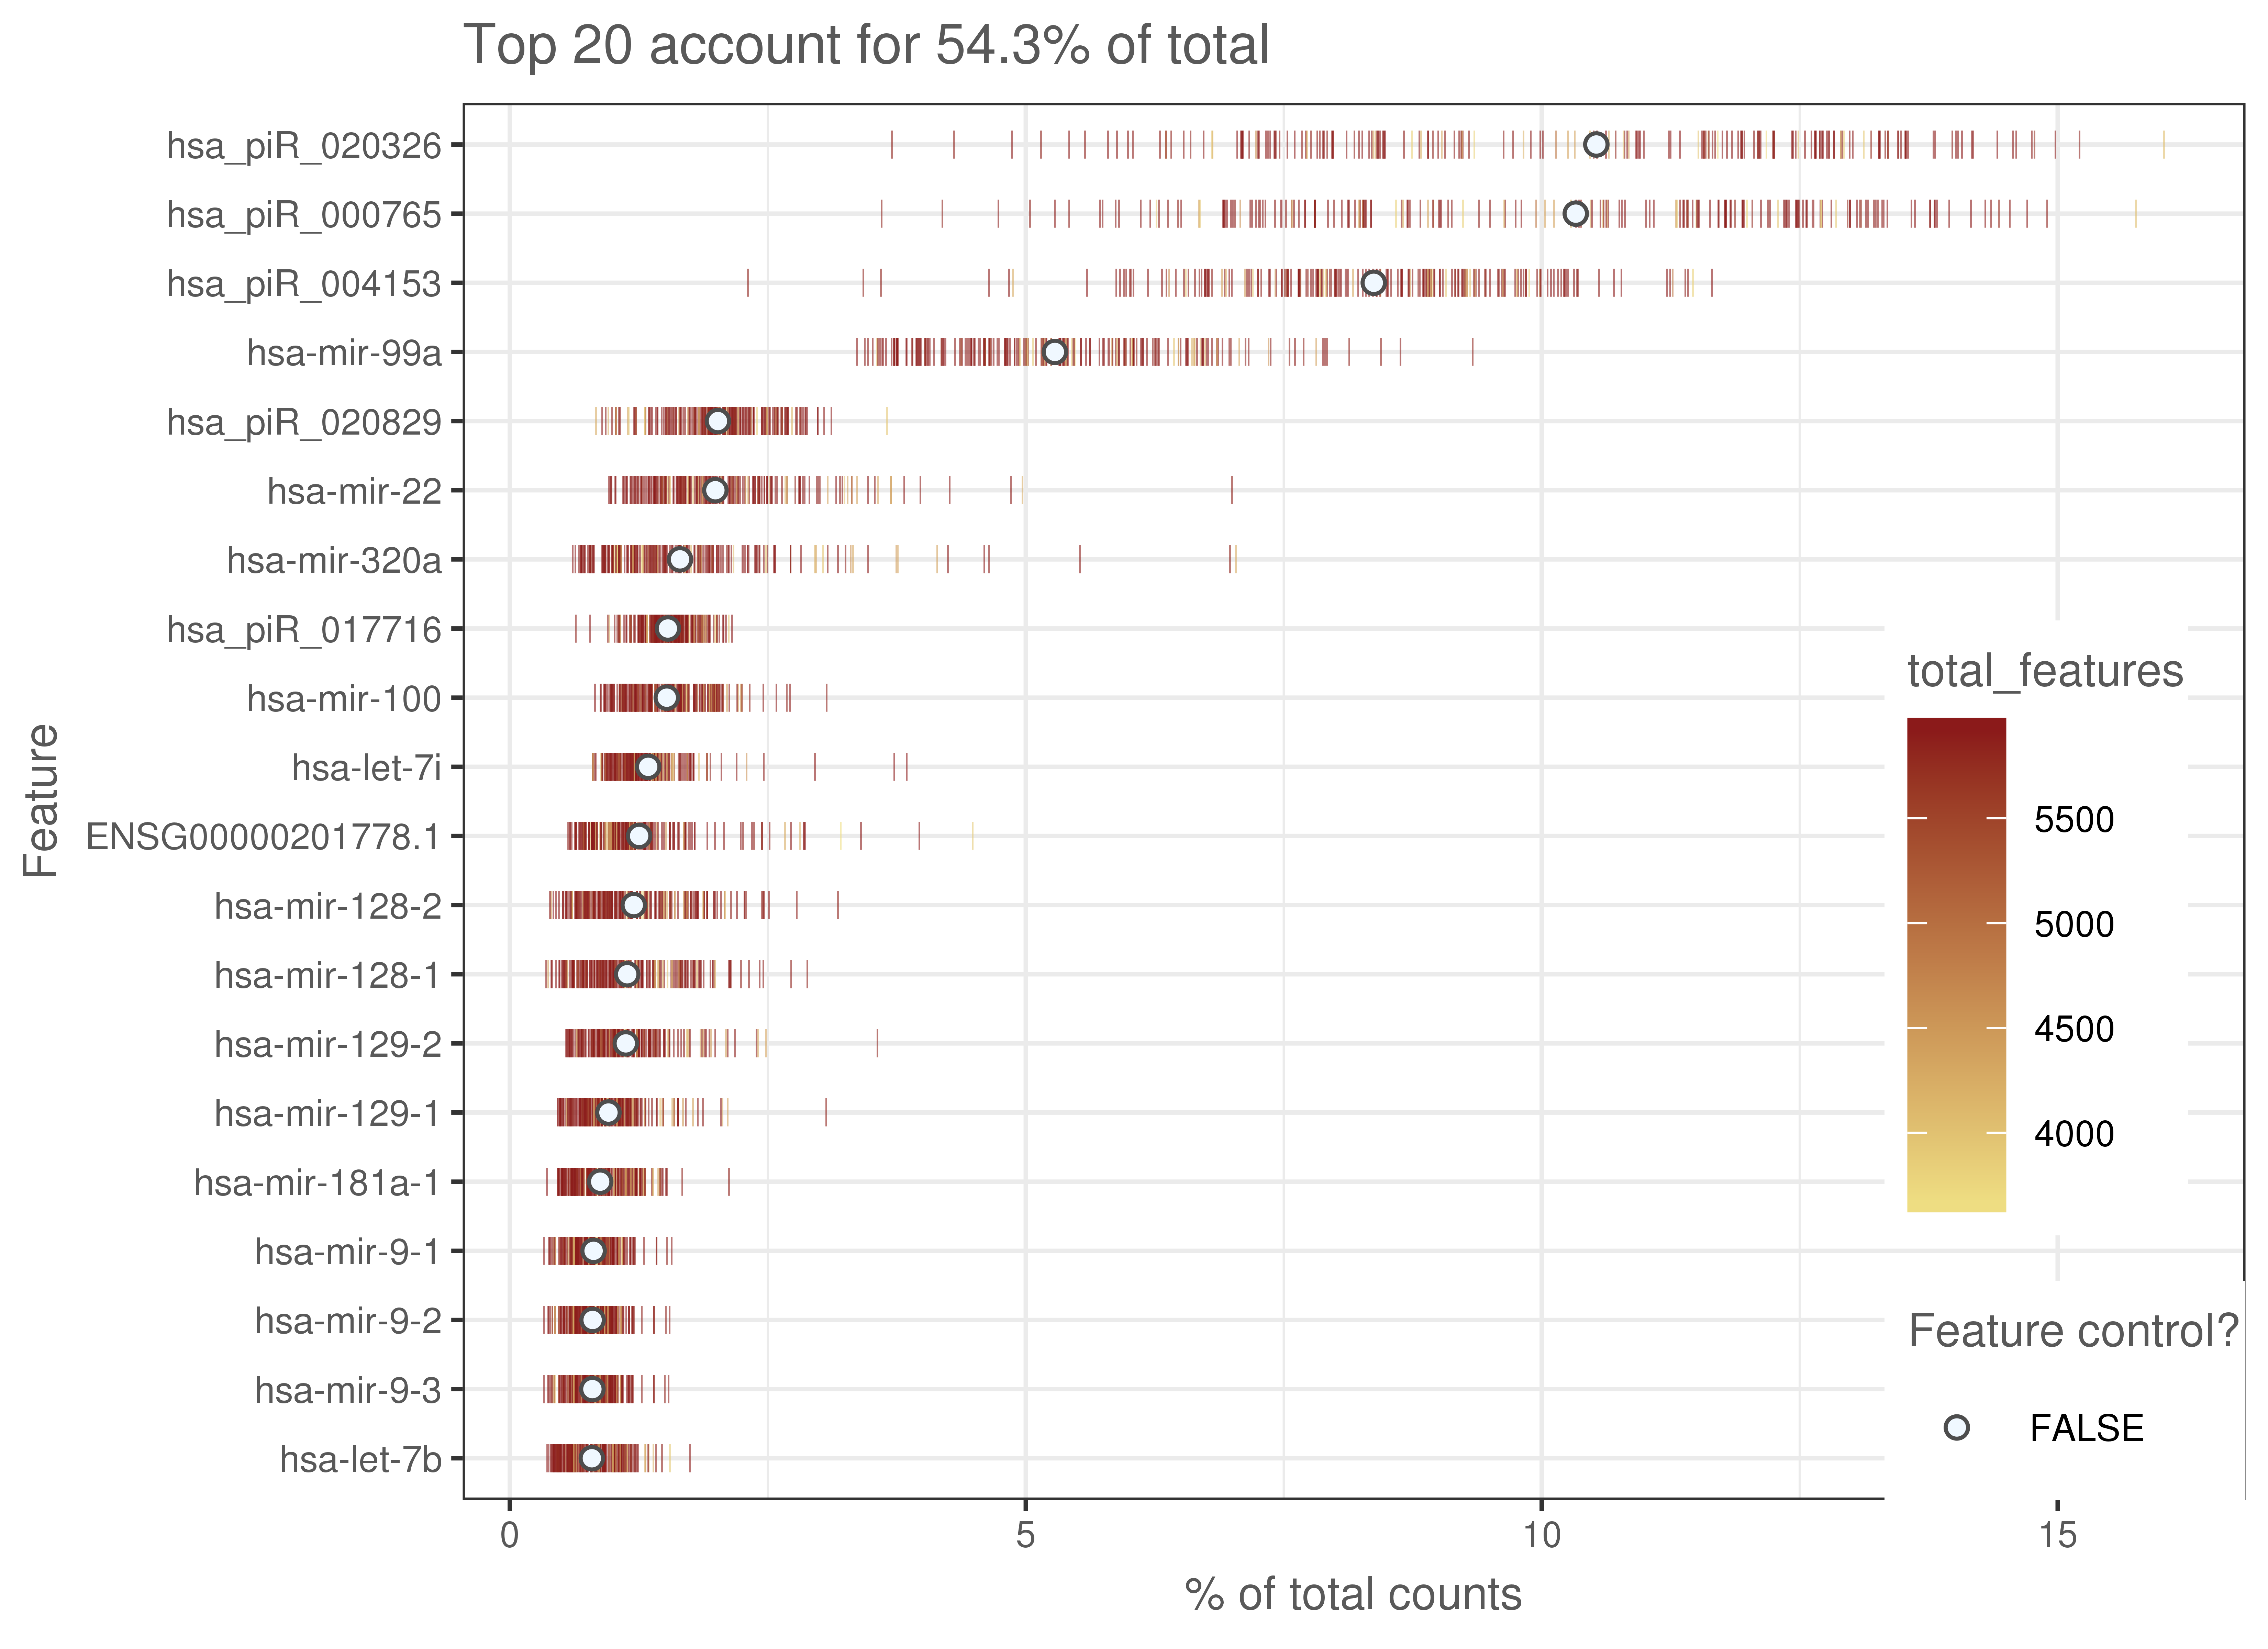

In [133]:
library(repr) 
options(repr.plot.width=5.5, repr.plot.height=4,repr.plot.res=1200) 
plot_highest_exprs(mat_filter_path)

In [62]:
scater::plotHighestExprs

function (object, col_by_variable = "total_features", n = 50, 
    drop_features = NULL, exprs_values = "counts", feature_names_to_plot = NULL) 
{
    if (!(col_by_variable %in% colnames(colData(object)))) {
        stop("col_by_variable not found in colData(object).\n             Please make sure colData(object)[, variable] exists.")
        plot_cols <- FALSE
    }
    else plot_cols <- TRUE
    x <- colData(object)[, col_by_variable]
    typeof_x <- .getTypeOfVariable(object, col_by_variable)
    if (!(is.null(drop_features) | length(drop_features) == 0)) {
        if (is.character(drop_features)) 
            drop_features <- which(rownames(object) %in% drop_features)
        if (is.logical(drop_features)) 
            object <- object[!drop_features, ]
        else object <- object[-drop_features, ]
    }
    if (!is.null(rowData(object)$is_feature_control)) 
        object <- calculateQCMetrics(object, feature_controls = list(all = rowData(object)$is_feature_control))
    else object <- calculateQCMetrics(object)
    exprs_values <- match.arg(exprs_values, c("logcounts", "tpm", 
        "cpm", "fpkm", "counts"))
    exprs_mat <- assay(object, exprs_values)
    if (is.null(exprs_mat) && !is.null(counts(object))) {
        exprs_mat <- counts(object)
        message("Using counts as expression values.")
        exprs_values <- "counts"
    }
    else if (is.null(exprs_mat)) {
        exprs_mat <- exprs(object)
        message("Using exprs(object) values as expression values.")
        exprs_values <- "logcounts"
    }
    if (exprs_values == "logcounts") 
        exprs_mat <- 2^exprs_mat - object@logExprsOffset
    rdata <- rowData(object)
    if (paste0("rank_", exprs_values) %in% colnames(rdata)) 
        oo <- order(rdata[[paste0("rank_", exprs_values)]], decreasing = TRUE)
    else {
        if ("rank_counts" %in% colnames(rdata)) {
            oo <- order(rdata[["rank_counts"]], decreasing = TRUE)
            exprs_values <- "counts"
            message("Using counts to order total expression of features.")
        }
        else {
            exprs_values <- "logcounts"
            oo <- order(rdata[["rank_exprs"]], decreasing = TRUE)
            message("Using 'exprs' to order total expression of features.")
        }
    }
    if (is.null(feature_names_to_plot) || is.null(rowData(object)[[feature_names_to_plot]])) 
        rdata$feature <- factor(rownames(object), levels = rownames(object)[rev(oo)])
    else rdata$feature <- factor(rowData(object)[[feature_names_to_plot]], 
        levels = rowData(object)[[feature_names_to_plot]][rev(oo)])
    rdata$Feature <- rdata$feature
    if (is.null(rdata$is_feature_control)) 
        rdata$is_feature_control <- rep(FALSE, nrow(rdata))
    total_exprs <- sum(exprs_mat)
    top50_pctage <- 100 * sum(.general_rowSums(exprs_mat)[oo[1:n]])/total_exprs
    df_pct_exprs_by_cell <- (100 * t(exprs_mat[oo[1:n], ])/.general_colSums(exprs_mat))
    pct_total <- 100 * .general_rowSums(exprs_mat)/total_exprs
    rdata[["pct_total"]] <- pct_total
    if (is.null(rownames(rdata))) 
        rownames(rdata) <- as.character(rdata$feature)
    df_pct_exprs_by_cell <- as.matrix(df_pct_exprs_by_cell)
    df_pct_exprs_by_cell_long <- reshape2::melt(df_pct_exprs_by_cell)
    colnames(df_pct_exprs_by_cell_long) <- c("Cell", "Tags", 
        "value")
    df_pct_exprs_by_cell_long$Feature <- rdata[as.character(df_pct_exprs_by_cell_long$Tags), 
        "feature"]
    df_pct_exprs_by_cell_long$Tags <- factor(df_pct_exprs_by_cell_long$Tags, 
        levels = rownames(object)[rev(oo[1:n])])
    df_pct_exprs_by_cell_long$Feature <- factor(df_pct_exprs_by_cell_long$Feature, 
        levels = rdata$feature[rev(oo[1:n])])
    if (typeof_x == "discrete") 
        df_pct_exprs_by_cell_long$colour_by <- factor(x)
    else df_pct_exprs_by_cell_long$colour_by <- x
    plot_most_expressed <- ggplot(df_pct_exprs_by_cell_long, 
        aes_string(y = "Feature", x = "value", colour = "colour_by")) + 
        geom_po

In [63]:
library(magrittr)
mat <- read.table(mat_filter_path, sep = "\t", header = TRUE, check.names = FALSE)

In [66]:
object <- mat %>% as_SingleCellExperiment() %>% {suppressMessages(scater::calculateQCMetrics(.))} 


In [69]:
colnames(SingleCellExperiment::colData(object))

[1] "total_features"              "log10_total_features"       
[3] "total_counts"                "log10_total_counts"         
[5] "pct_counts_top_50_features"  "pct_counts_top_100_features"
[7] "pct_counts_top_200_features" "pct_counts_top_500_features"
[9] "is_cell_control"

In [71]:
x = SingleCellExperiment::colData(object)[, "total_features"]

In [76]:
getTypeOfVariable <- function(object, variable) {
    ## Extract variable
    x <- SingleCellExperiment::colData(object)[, variable]
    ## Get type
    if (is.character(x) || is.factor(x) || is.logical(x)) {
        typeof_x <- "discrete"
    } else {
        if (is.integer(x)) {
            if (length(unique(x)) > 10) 
                typeof_x <- "continuous" else typeof_x <- "discrete"
        } else {
            if (is.numeric(x)) 
                typeof_x <- "continuous" else {
                x <- as.character(x)
                typeof_x <- "discrete"
                warning(paste0("Unrecognised variable type for ", variable, ". Variable being coerced to discrete. Please make sure colData(object)[, variable] is a proper discrete or continuous variable"))
            }
        }
    }
    typeof_x
}

In [78]:
typeof_x <- getTypeOfVariable(object, "total_features")
typeof_x

[1] "continuous"

In [79]:
drop_features = NULL

In [80]:
!(is.null(drop_features) | length(drop_features) == 0)

[1] FALSE

In [107]:
as.matrix(SingleCellExperiment::rowData(object))[353,]

is_feature_control        mean_counts  log10_mean_counts        rank_counts 
      0.000000e+00       7.063854e+05       5.849042e+00       5.924000e+03 
    n_cells_counts pct_dropout_counts       total_counts log10_total_counts 
      1.920000e+02       0.000000e+00       1.356260e+08       8.132343e+00

In [94]:
order(SingleCellExperiment::rowData(object)[["rank_counts"]],decreasing = TRUE)

[1]  423  353  366  348  439  154  190  404   14   11 1079   50   49   53
  [15]   52  100  336  337  338    4  102  140  101  184  418  103  820  851
  [29]  818  466  821  506  714  817  522  527  531  857  349  854  860  863
  [43]  599  712  571  180  168  259  233   48  252   79  434  390  185  312
  [57]  270  429   15   84  844  840  670  842  838   42   16  703  431  586
  [71]  243  411  327  835  293  153  362   41  686  161  198   88  410  162
  [85]   77   33   35   34  389  339  155  171 1070  361  530  581  699  601
  [99]  652  583  582  451  647  987  340   31 3089  258  420   10 5899  415
 [113]   43  425   64  395  435  248  430  110   40  384  206   72  156 4014
 [127]  213  105  433  426 3083   85 1761  459  774  776   30  869  164  277
 [141]  512  852  855  864  858  460  861  483 1906  422    5  242  276   82
 [155]  165  150  341    6  374  325  354  203 1737  324  159  151 1015  316
 [169]   76  116  163 1613  335  202 3041  697  672  191  192 1872  315  833
 [183]  167  244 1091   98  356 3649  990   97  111 1617  365  220  615  401
 [197] 1647  501  976 1030  211 1031   36  866  219  528  675    1  523    3
 [211]  519 5795  334  594  137 1863 3002  331  674  169  136    2   26 1024
 [225] 1013   75   57   25  980   74 2667  704  249  991  687    9  667 1086
 [239]   67 5074 1172  170  288 2404  254  575  578  680  297 1073  576  577
 [253]   18 3400  793  700  539  867  808  804 1083  815   17  673  800 3977
 [267]  419  282  589  608  810  803  432  635   81  470 2081  618  802  160
 [281]    8  473  476  827 1162 1948 1176 1158 1208 1154  247 1203 1155 1926
 [295]   90  235 1197    7   20 1790 5824 1085  606  872 1938  328  871  747
 [309]  503 1890  351 3428  332   19 4749 3423  645  504  461  499  750 5071
 [323]  713  485  132   24 1202  287 3699 3232  457 3594 5072 1062 3491  609
 [337]  656 2639  286  595  397  280  194  605  223  421 3563  193  471  144
 [351]  208 1153 2974  495   73 3239  204  319  104  226  119  205  174  717
 [365]  436   61 3533 3537 1201  517 3427  455  406 1961  275  232  979 4913
 [379]  971  502  377  736  572  655  769  508 1281  688  450  785  734  458
 [393]   62 3169 4076 4260  272  405 4315 1808  393 3828  500  342 3051 1023
 [407] 3526 4970  993 5277  311 1842  689 2873  809  807  903  782  542   56
 [421] 4876  321  602   78 1045  828 1488 5193  400  195 1078 3845 1402 1714
 [435]  568  692  567  323 4022  468 1443  322 2468 2456 3687 2459 3881  245
 [449] 1979 5400 1532 2462 1037  716  467 2465  534  489  444 2632  634 2964
 [463]  481  564 2830  566  250  543  526  465  237  598 4442  126  668 1174
 [477]  985 3052 3050  682  370  236  127  152  545  229  456 4775  345  182
 [491] 3857 1252  128 1051  696  138  658 1605 1753  183  766 5009  196  646
 [505] 2283 3481 3999 4784   23 3055 2513  829  627  834  622 4089  573  630
 [519]  777   80 1146 3971  846  830  806 3221  625  166  832  579 3012  947
 [533] 1160 4799 1200 1857 2189 3868 1185 3640  241 2440  970 3559 1022 2125
 [547]  795 2839 3873 1927 2370 2872 4150 1940 1955 1720 1966 1928 3129 1972
 [561]  591 1947  284 1951 2734 1950 1964 1942 1958  469 1959  691 2826  661
 [575] 1999  773   93 3834 1116  309  308 1189   83  694  124 5165  775 3893
 [589]  518  607  799 1768  824  533  759 2335  797 1941  263 5489 1026 1192
 [603] 4366 2575 1259 2079 5873 1184 4434 3451  188 4880 5128 1957  574 4021
 [617]  783 5888 2750 4318  723  812  780  927 5040  788 1943  493  130 1423
 [631] 2791 2427   60 1922  131 3059 3792  742 3508  279  141  659  640  511
 [645] 1924  558  781 1390 2938  551 3592 5641 2812 5361 5473 1218 1179 3728
 [659]  427 1820  296  157  368 5749 2323 1406 1335 5129 1286 1275 3752  369
 [673] 1257  614 1750 1276 1280 1308  367 5161   68  720 1915  999 4601  490
 [687] 1349 3878 1038 3626 1048 5390 4717 2319 1619 1060  285  905 1115  200
 [701] 3286 1310  449  268 4494  291  684 1353 5291 3161  314 4984 1095  559
 [715] 5544 4469 1590  257 1217 1454  939  877 4776 3912 4507 5185  521 1055

In [51]:
level(name)

ERROR: Error in level(name): could not find function "level"


In [39]:
setdiff(unique(name),name)

character(0)

In [36]:
length(rownames(mat))

[1] 5925

In [37]:
length(unique(rownames(mat)))

[1] 5925

In [ ]:
library(magrittr)
mat <- read.table(mat_filter_path, sep = "\t", header = TRUE, check.names = FALSE)
name <- c()
for (i in seq_len(length(rownames(mat)))) {
    name[i] <- paste(unlist(strsplit(rownames(mat)[i], "|", fixed = T))[1], unlist(strsplit(rownames(mat)[i], 
        "|", fixed = T))[2], unlist(strsplit(rownames(mat)[i], "|", fixed = T))[3], 
        sep = "|")
}
row.names(mat) <- name
mat %>% as_SingleCellExperiment() %>% {
    suppressMessages(scater::calculateQCMetrics(.))
} %>% scater::plotHighestExprs(n = top_n)

In [32]:
%%R
plt.rcParams['savefig.dpi'] = 300 #图片像素
plt.rcParams['figure.dpi'] = 300 #分辨率
library(ggplot2)
#options(repr.plot.width=4, repr.plot.height=3,repr.plot.res=300)
plot_highest_exprs(mat_filter_path)



Error in plt.rcParams["savefig.dpi"] = 300 : 
  object 'plt.rcParams' not found


/apps/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Error in plt.rcParams["savefig.dpi"] = 300 : 
  object 'plt.rcParams' not found

  warnings.warn(x, RRuntimeWarning)


## count_depth plot

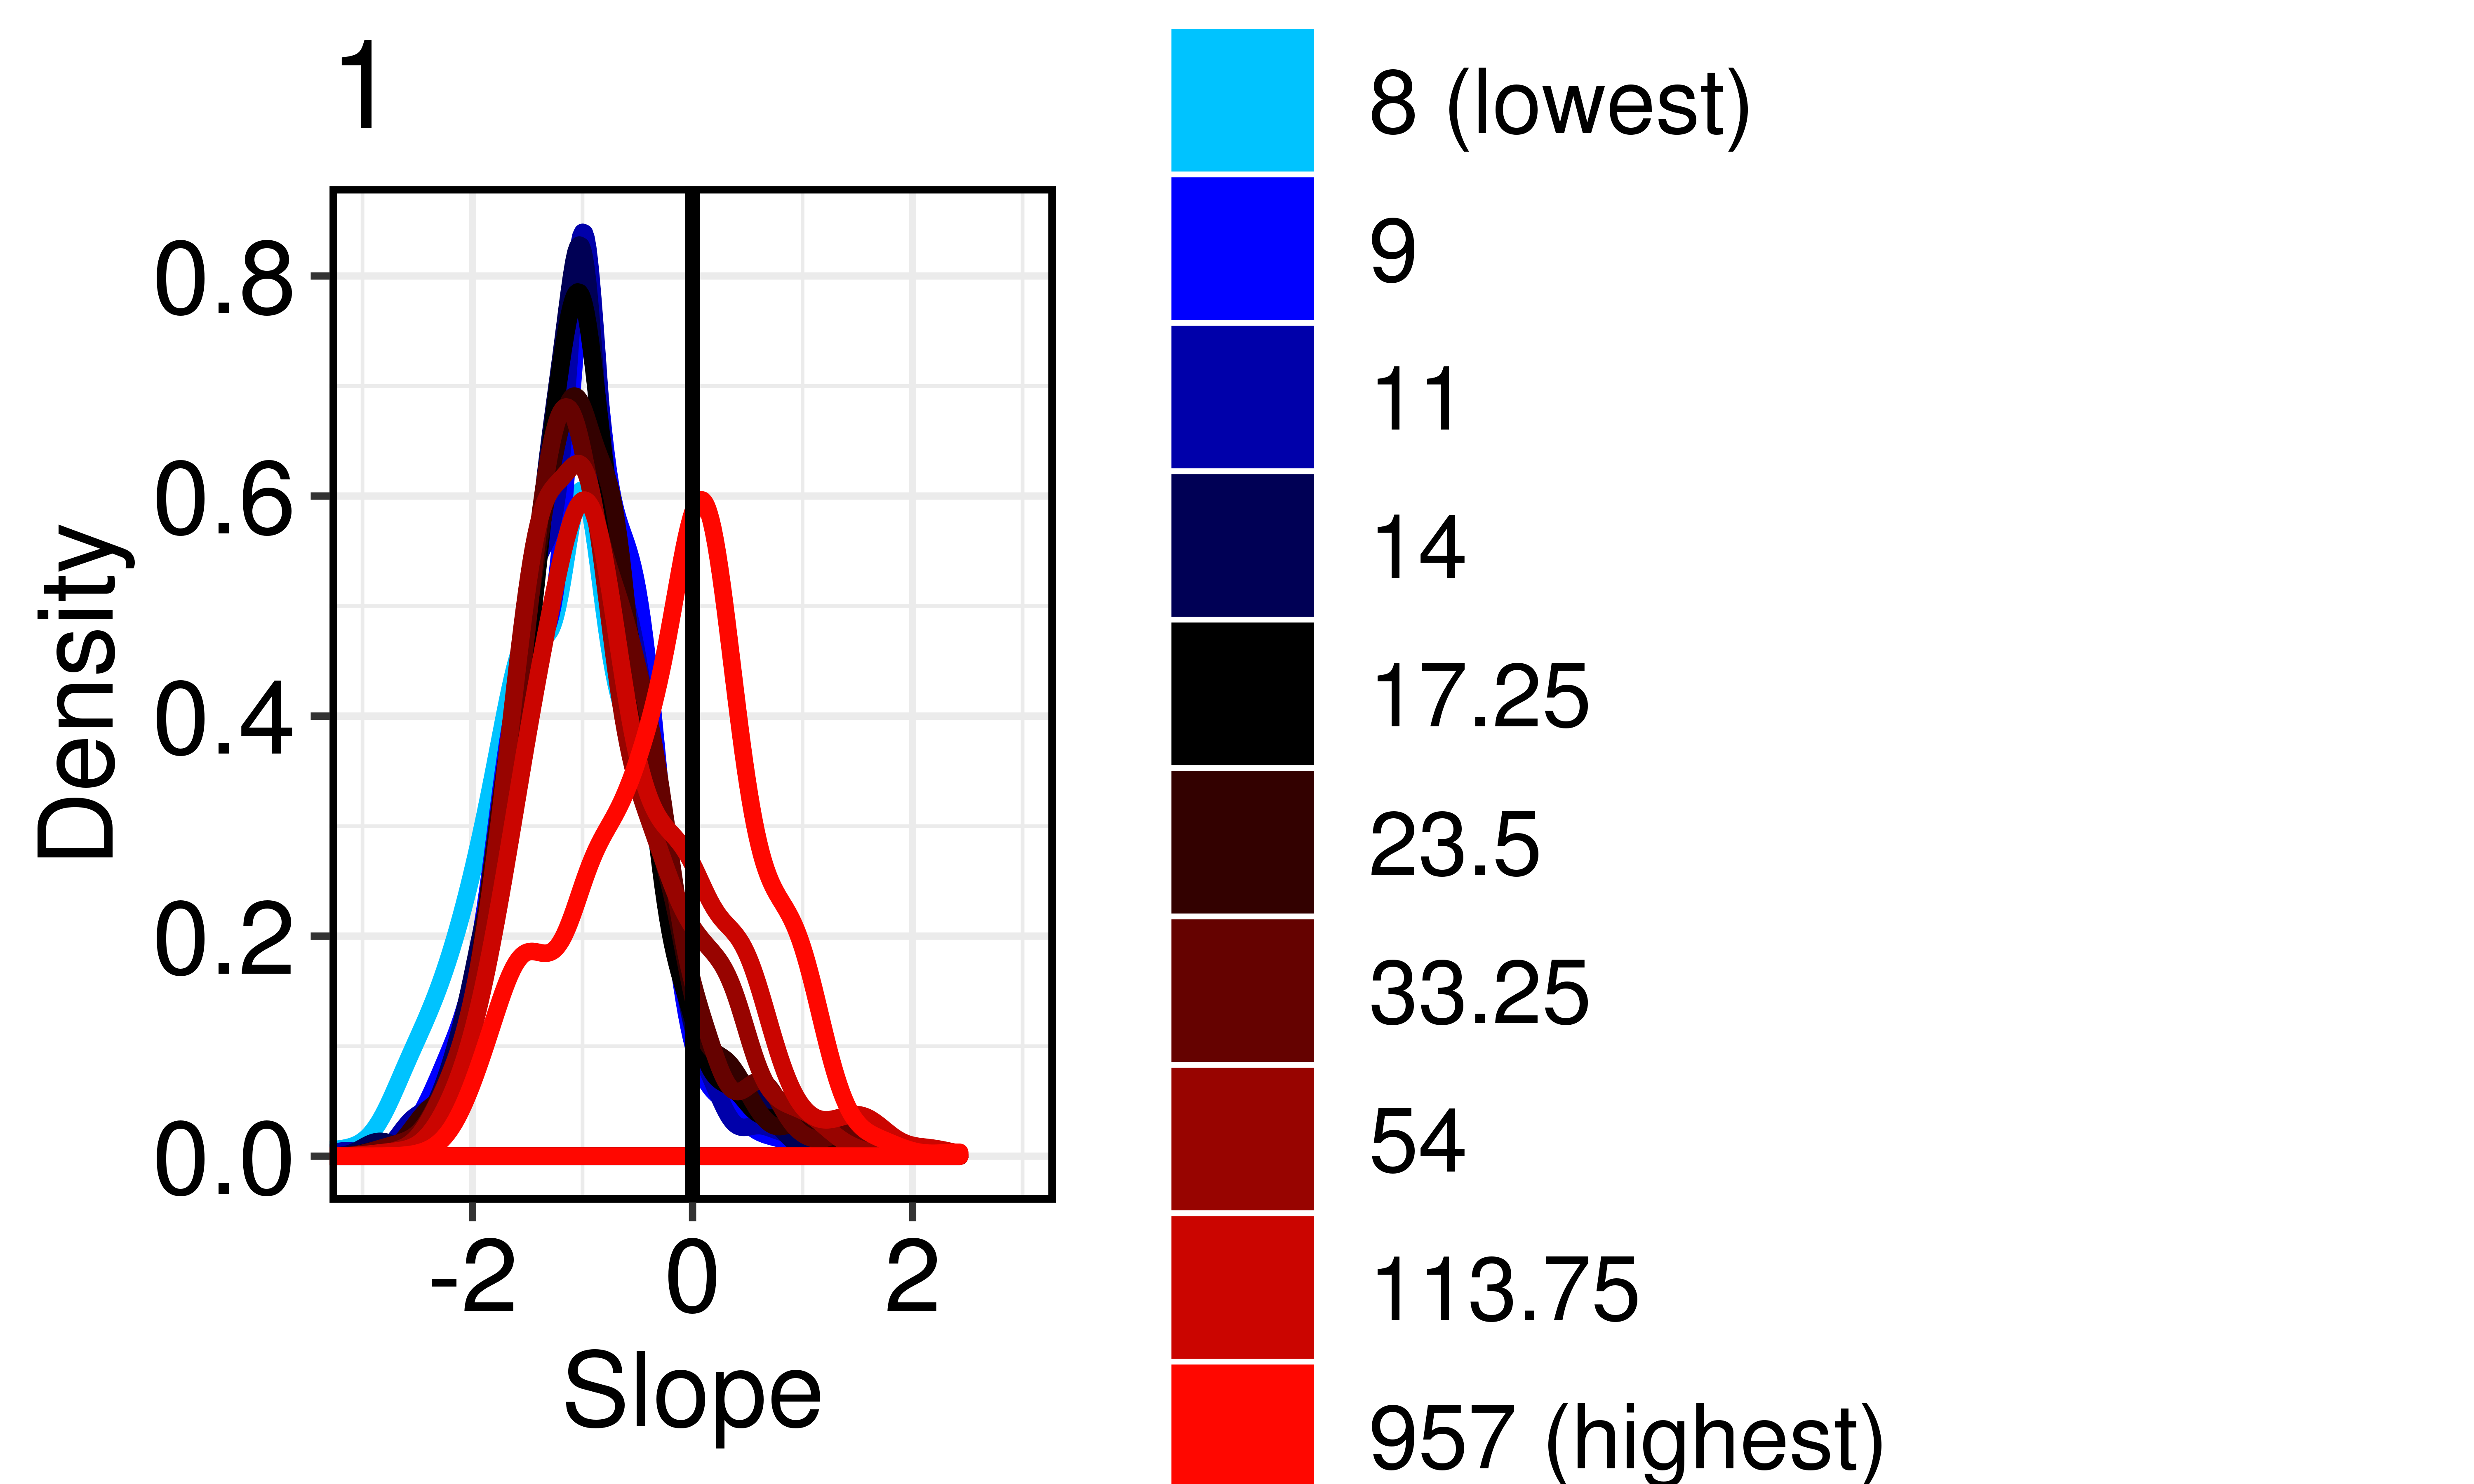

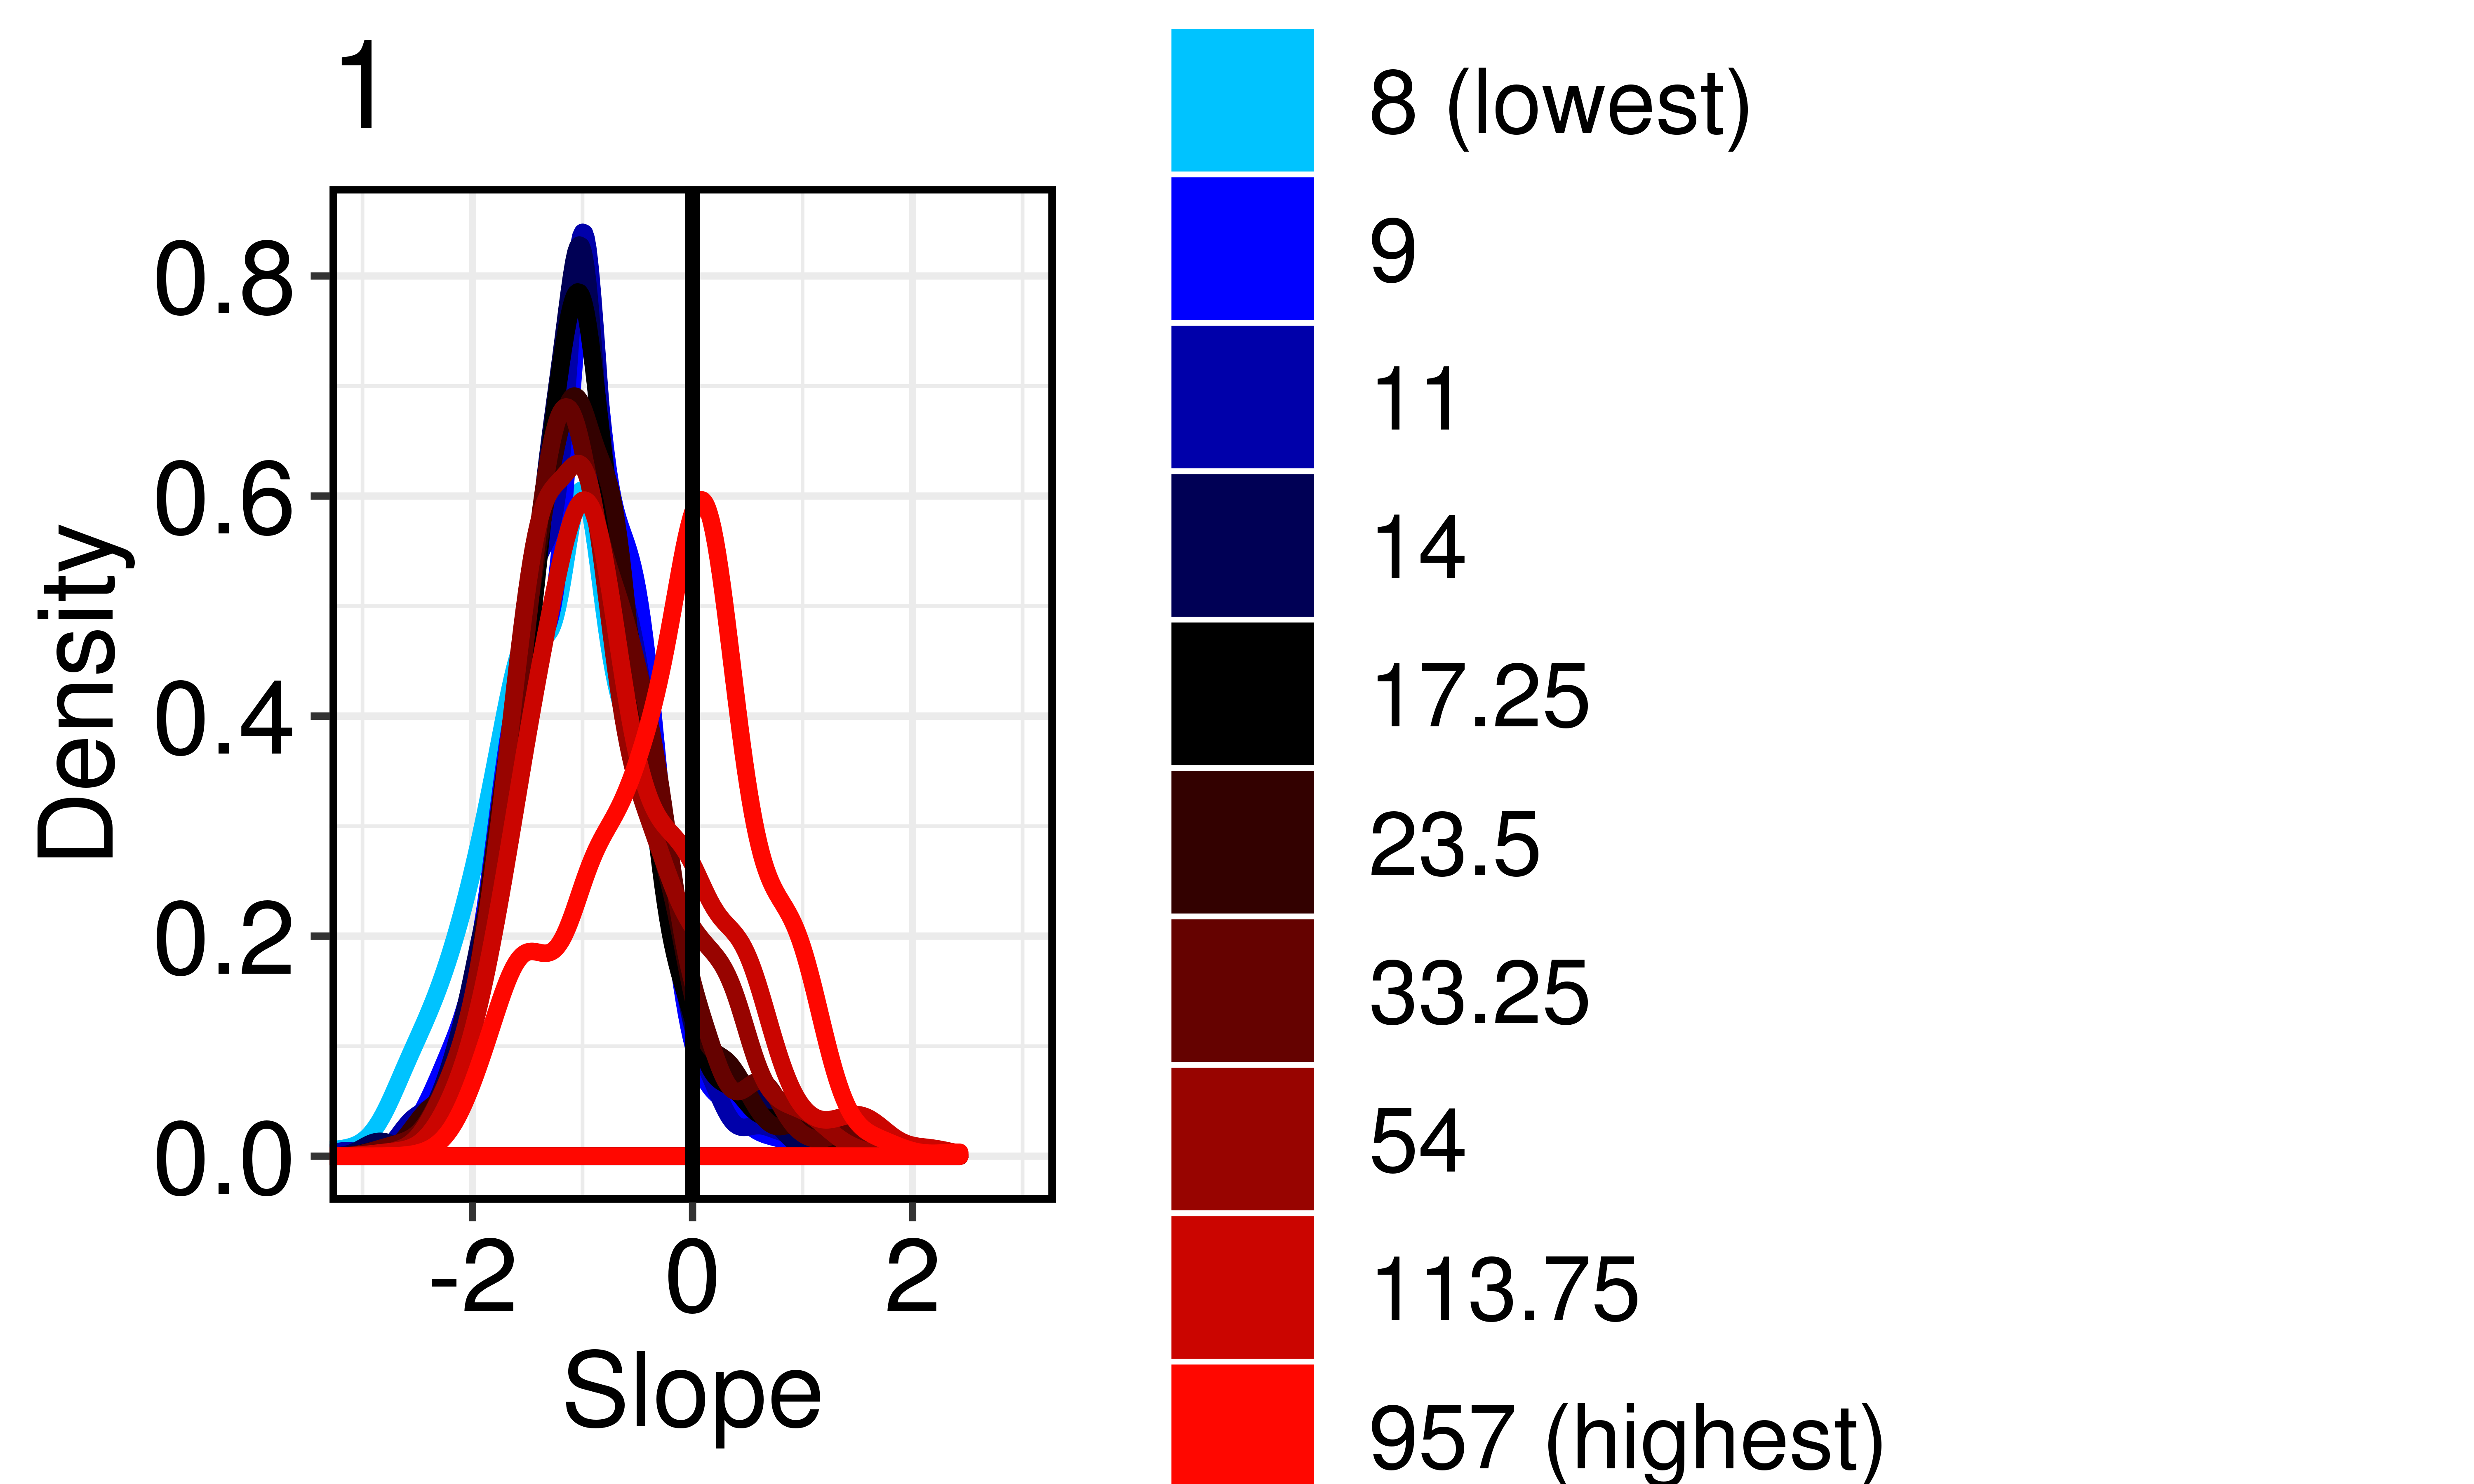

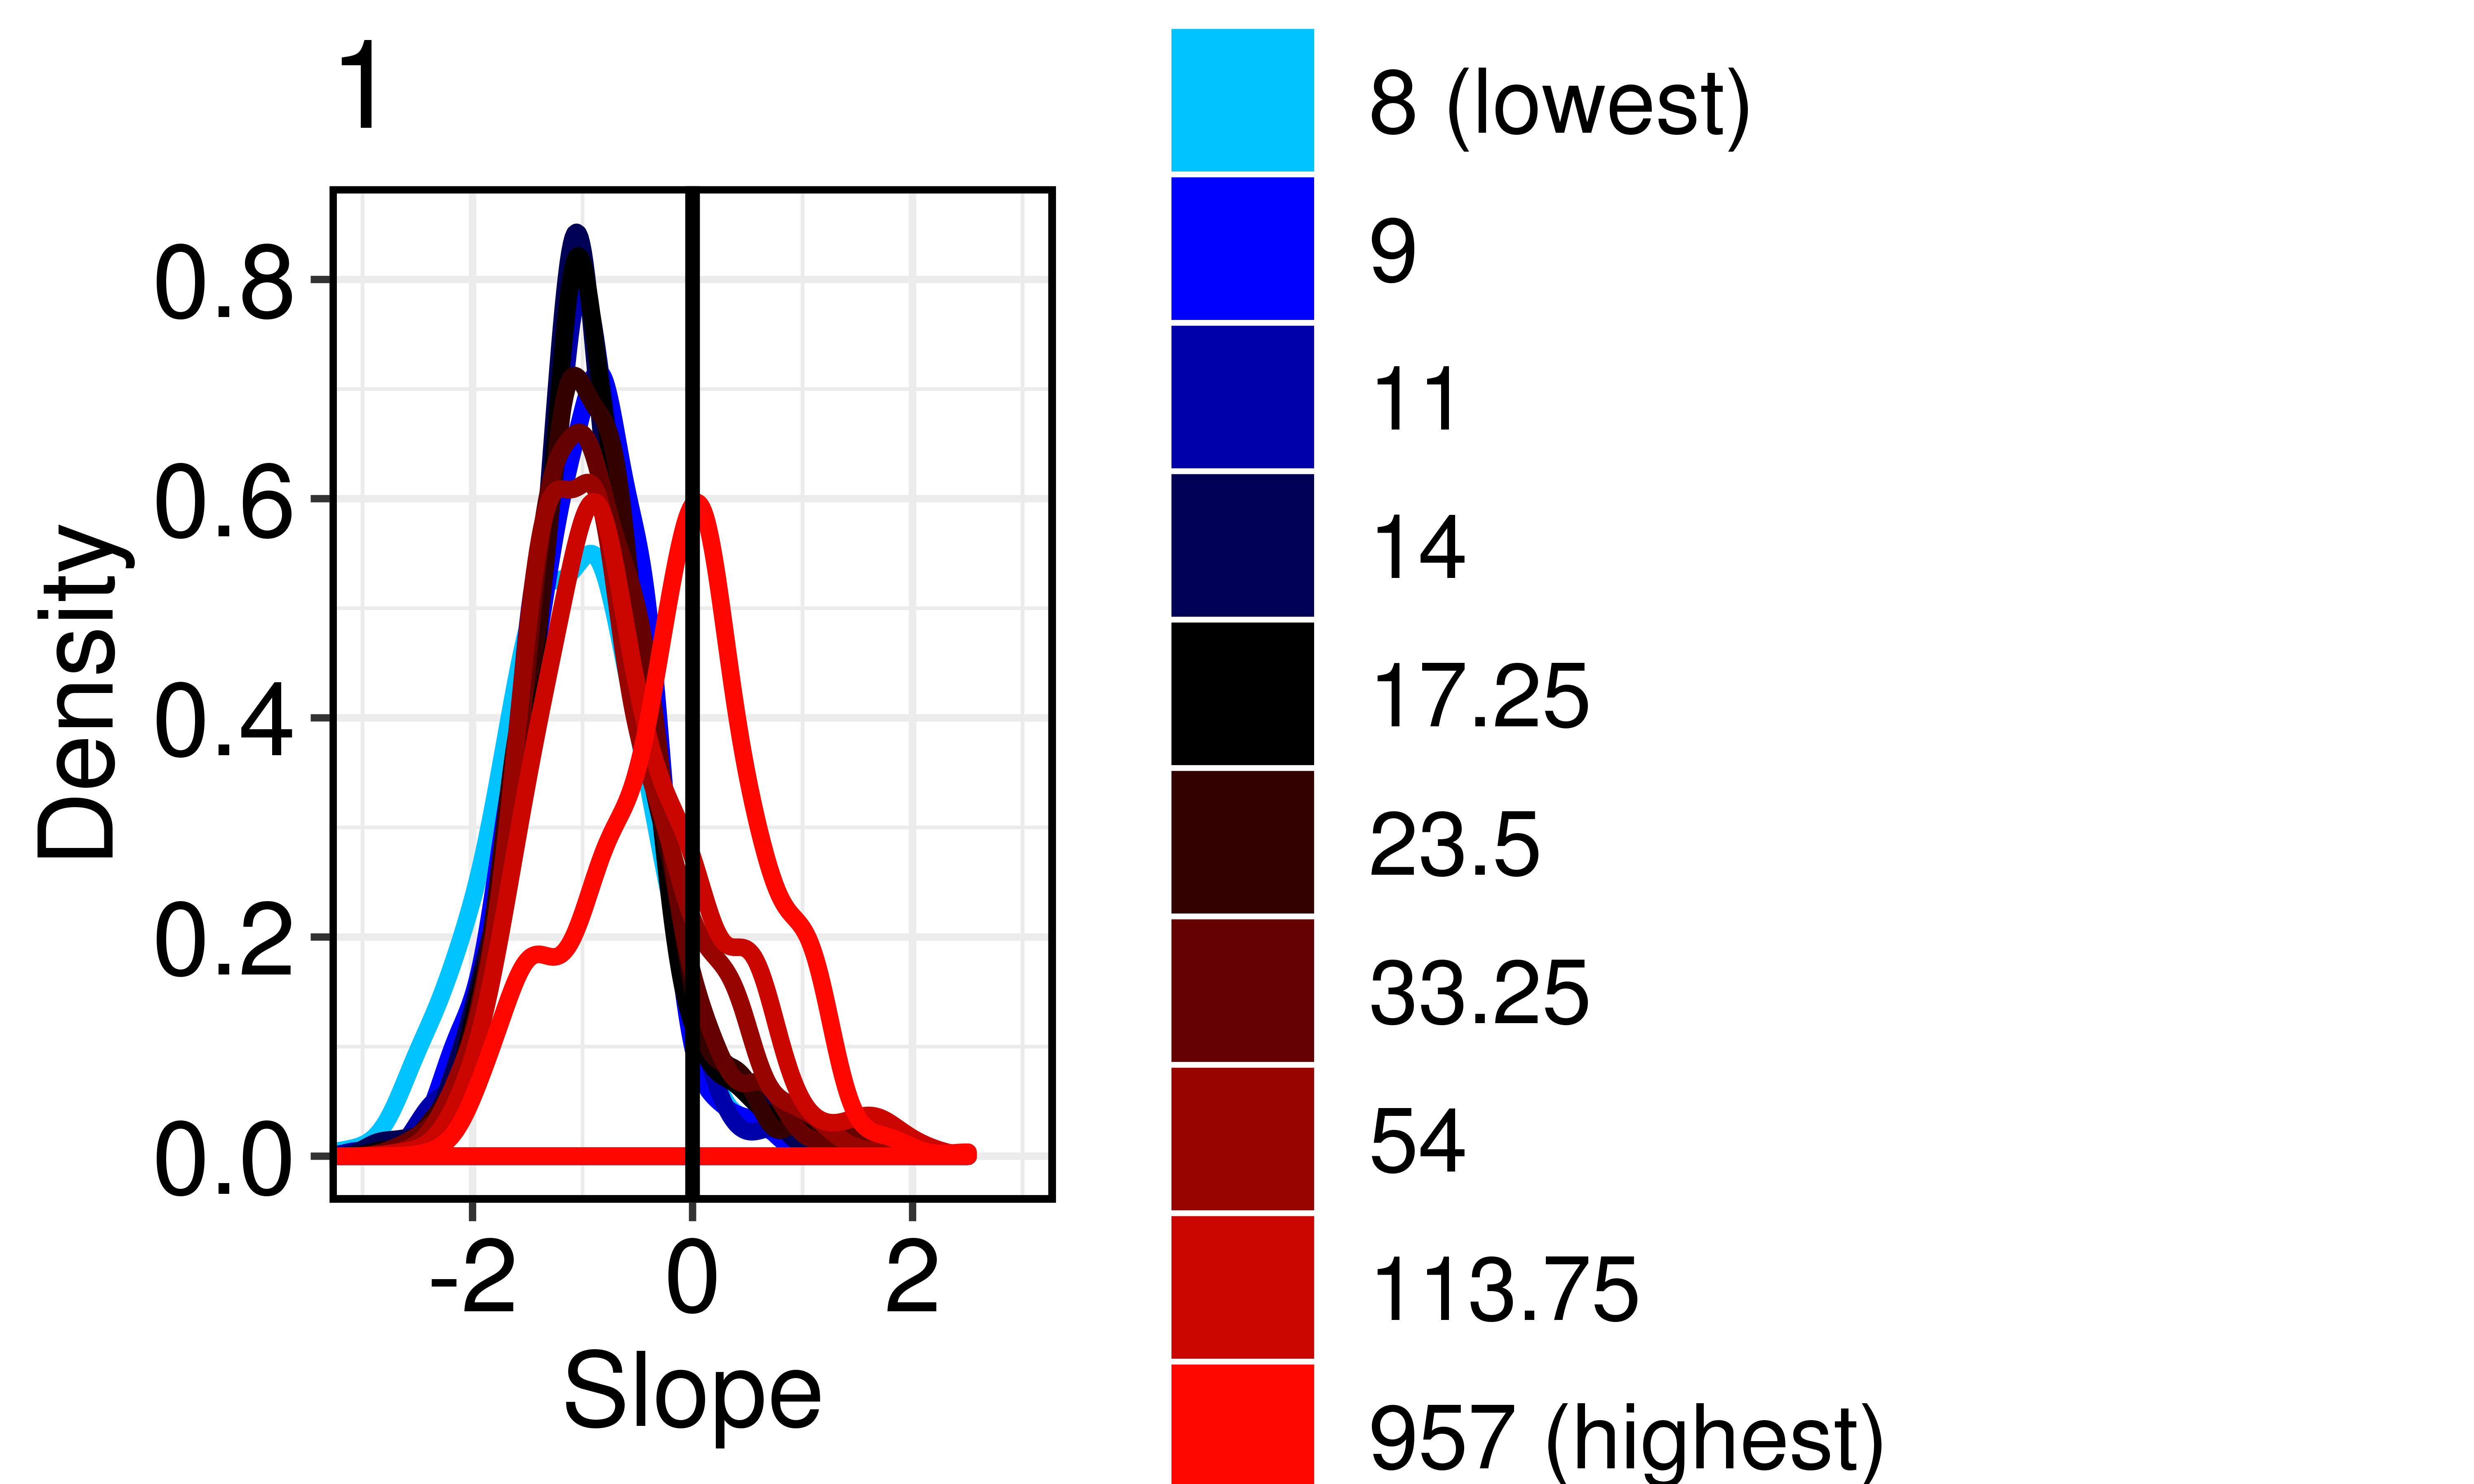

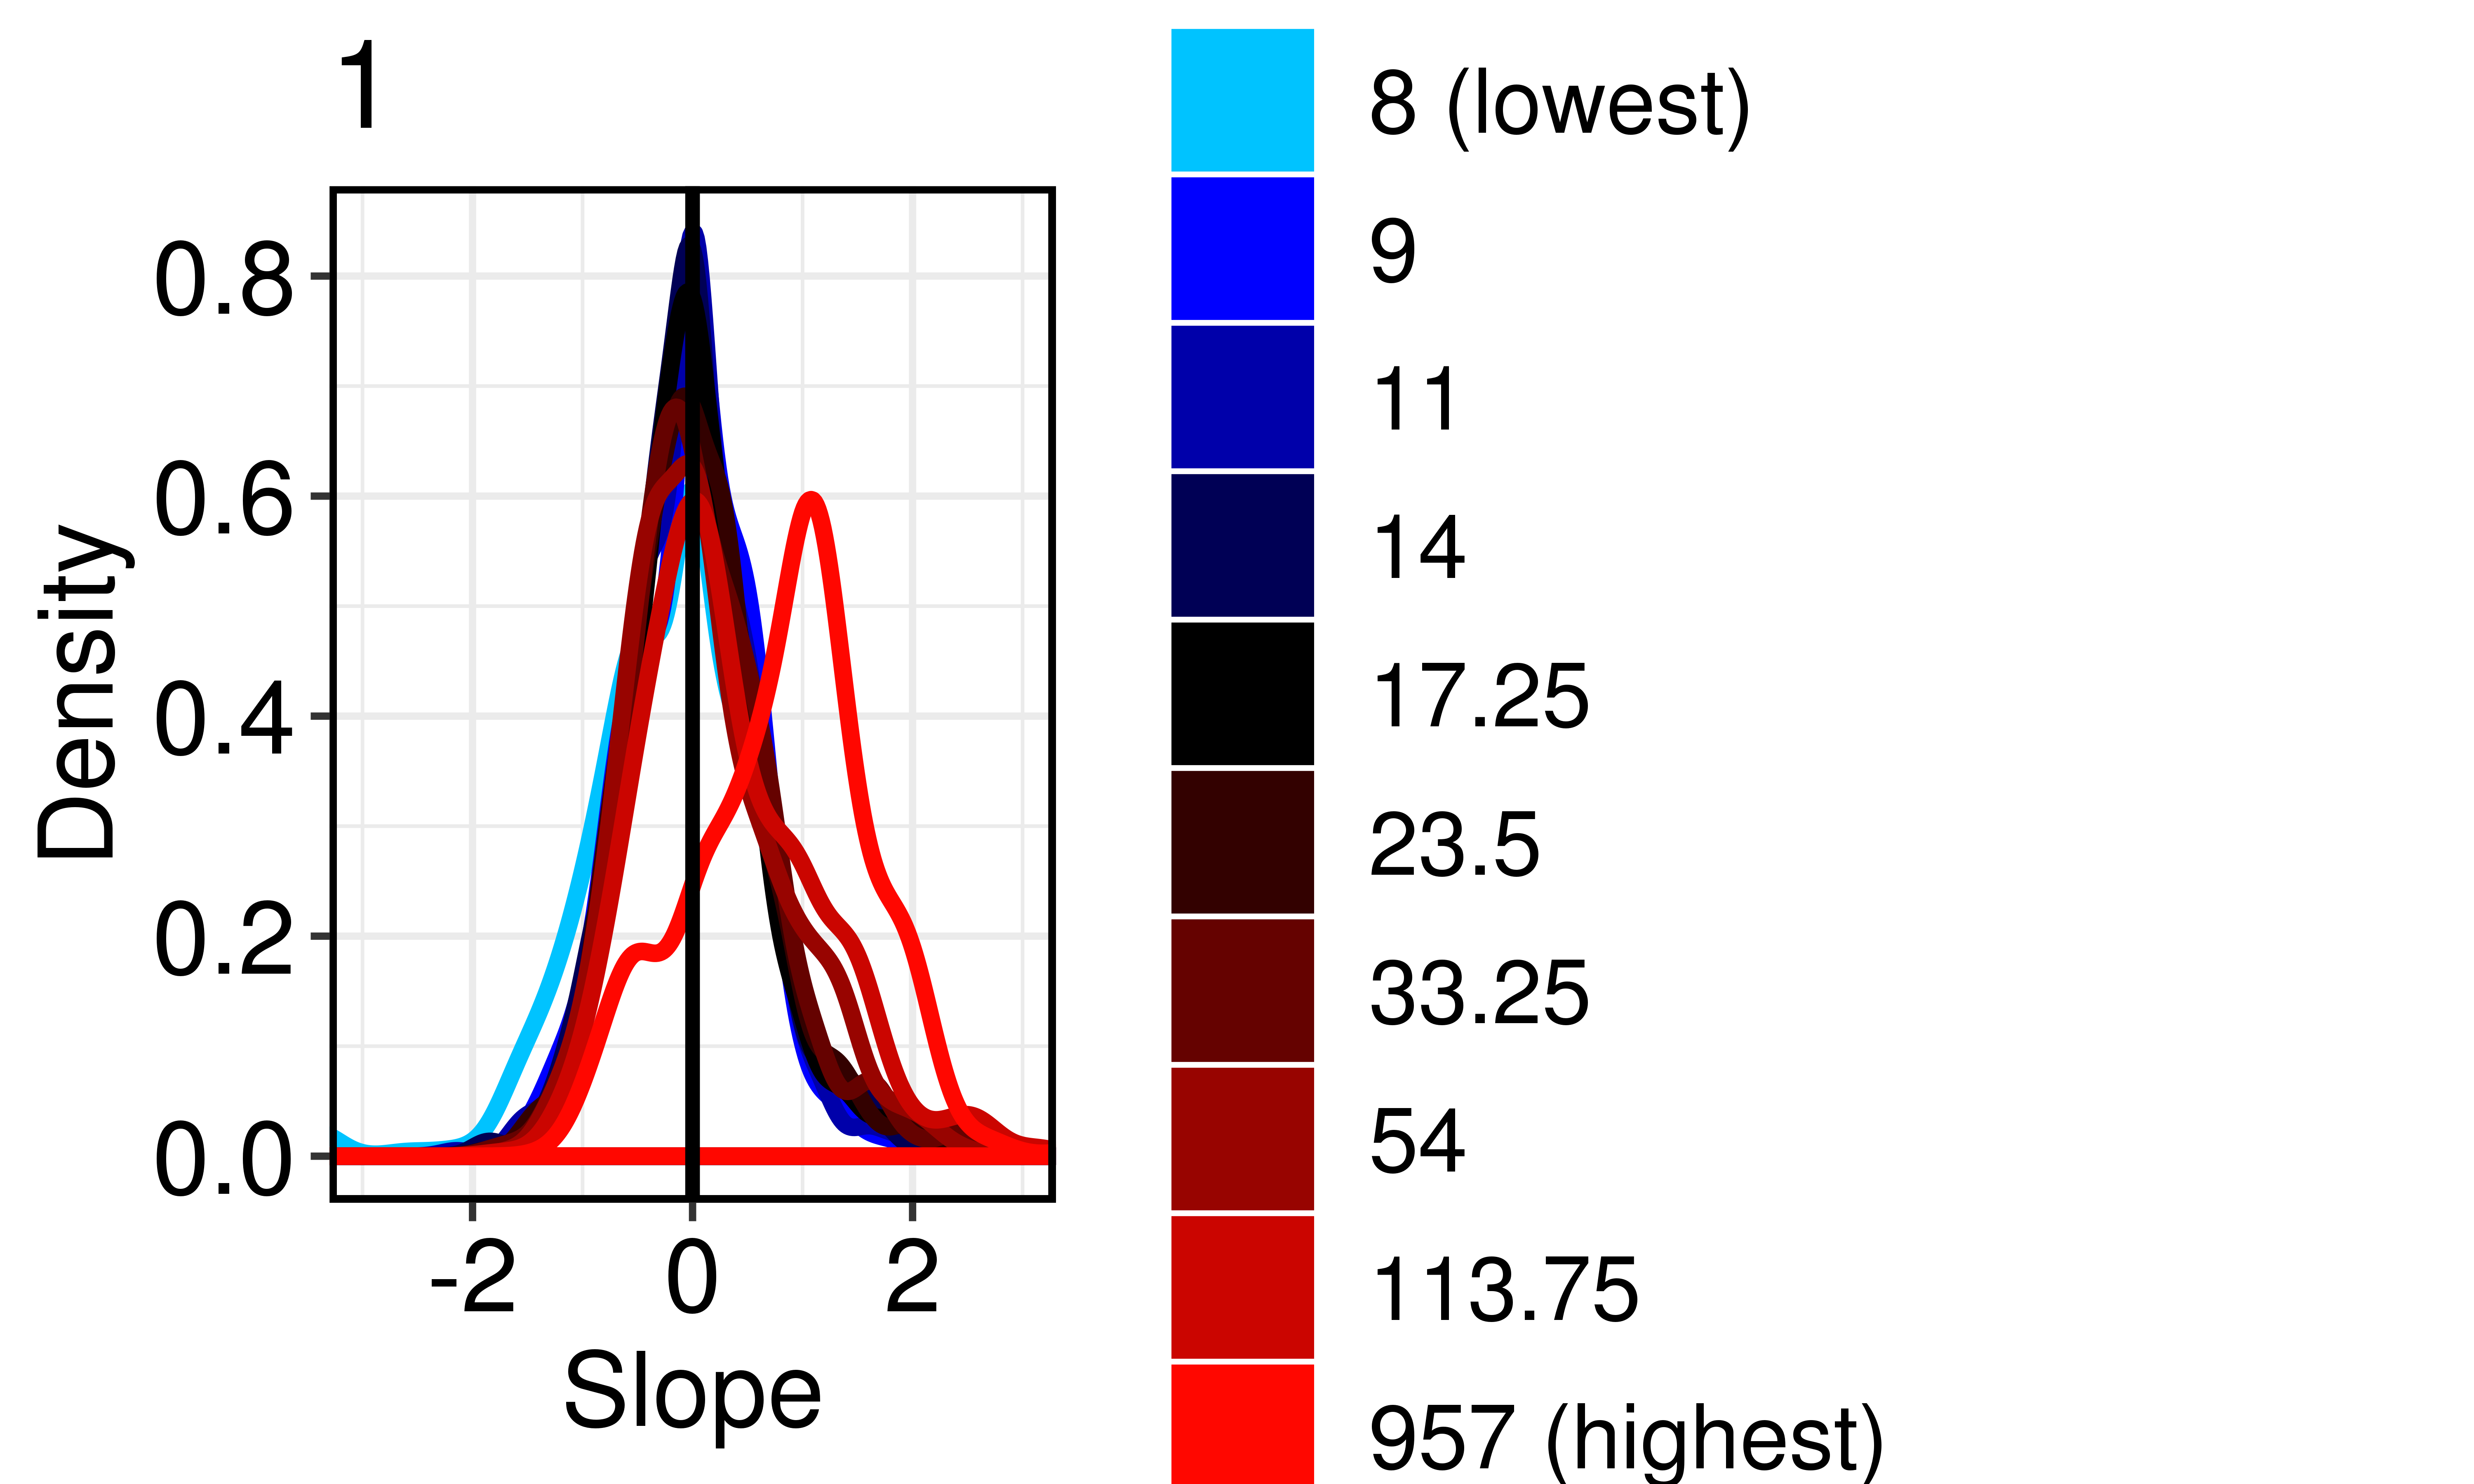

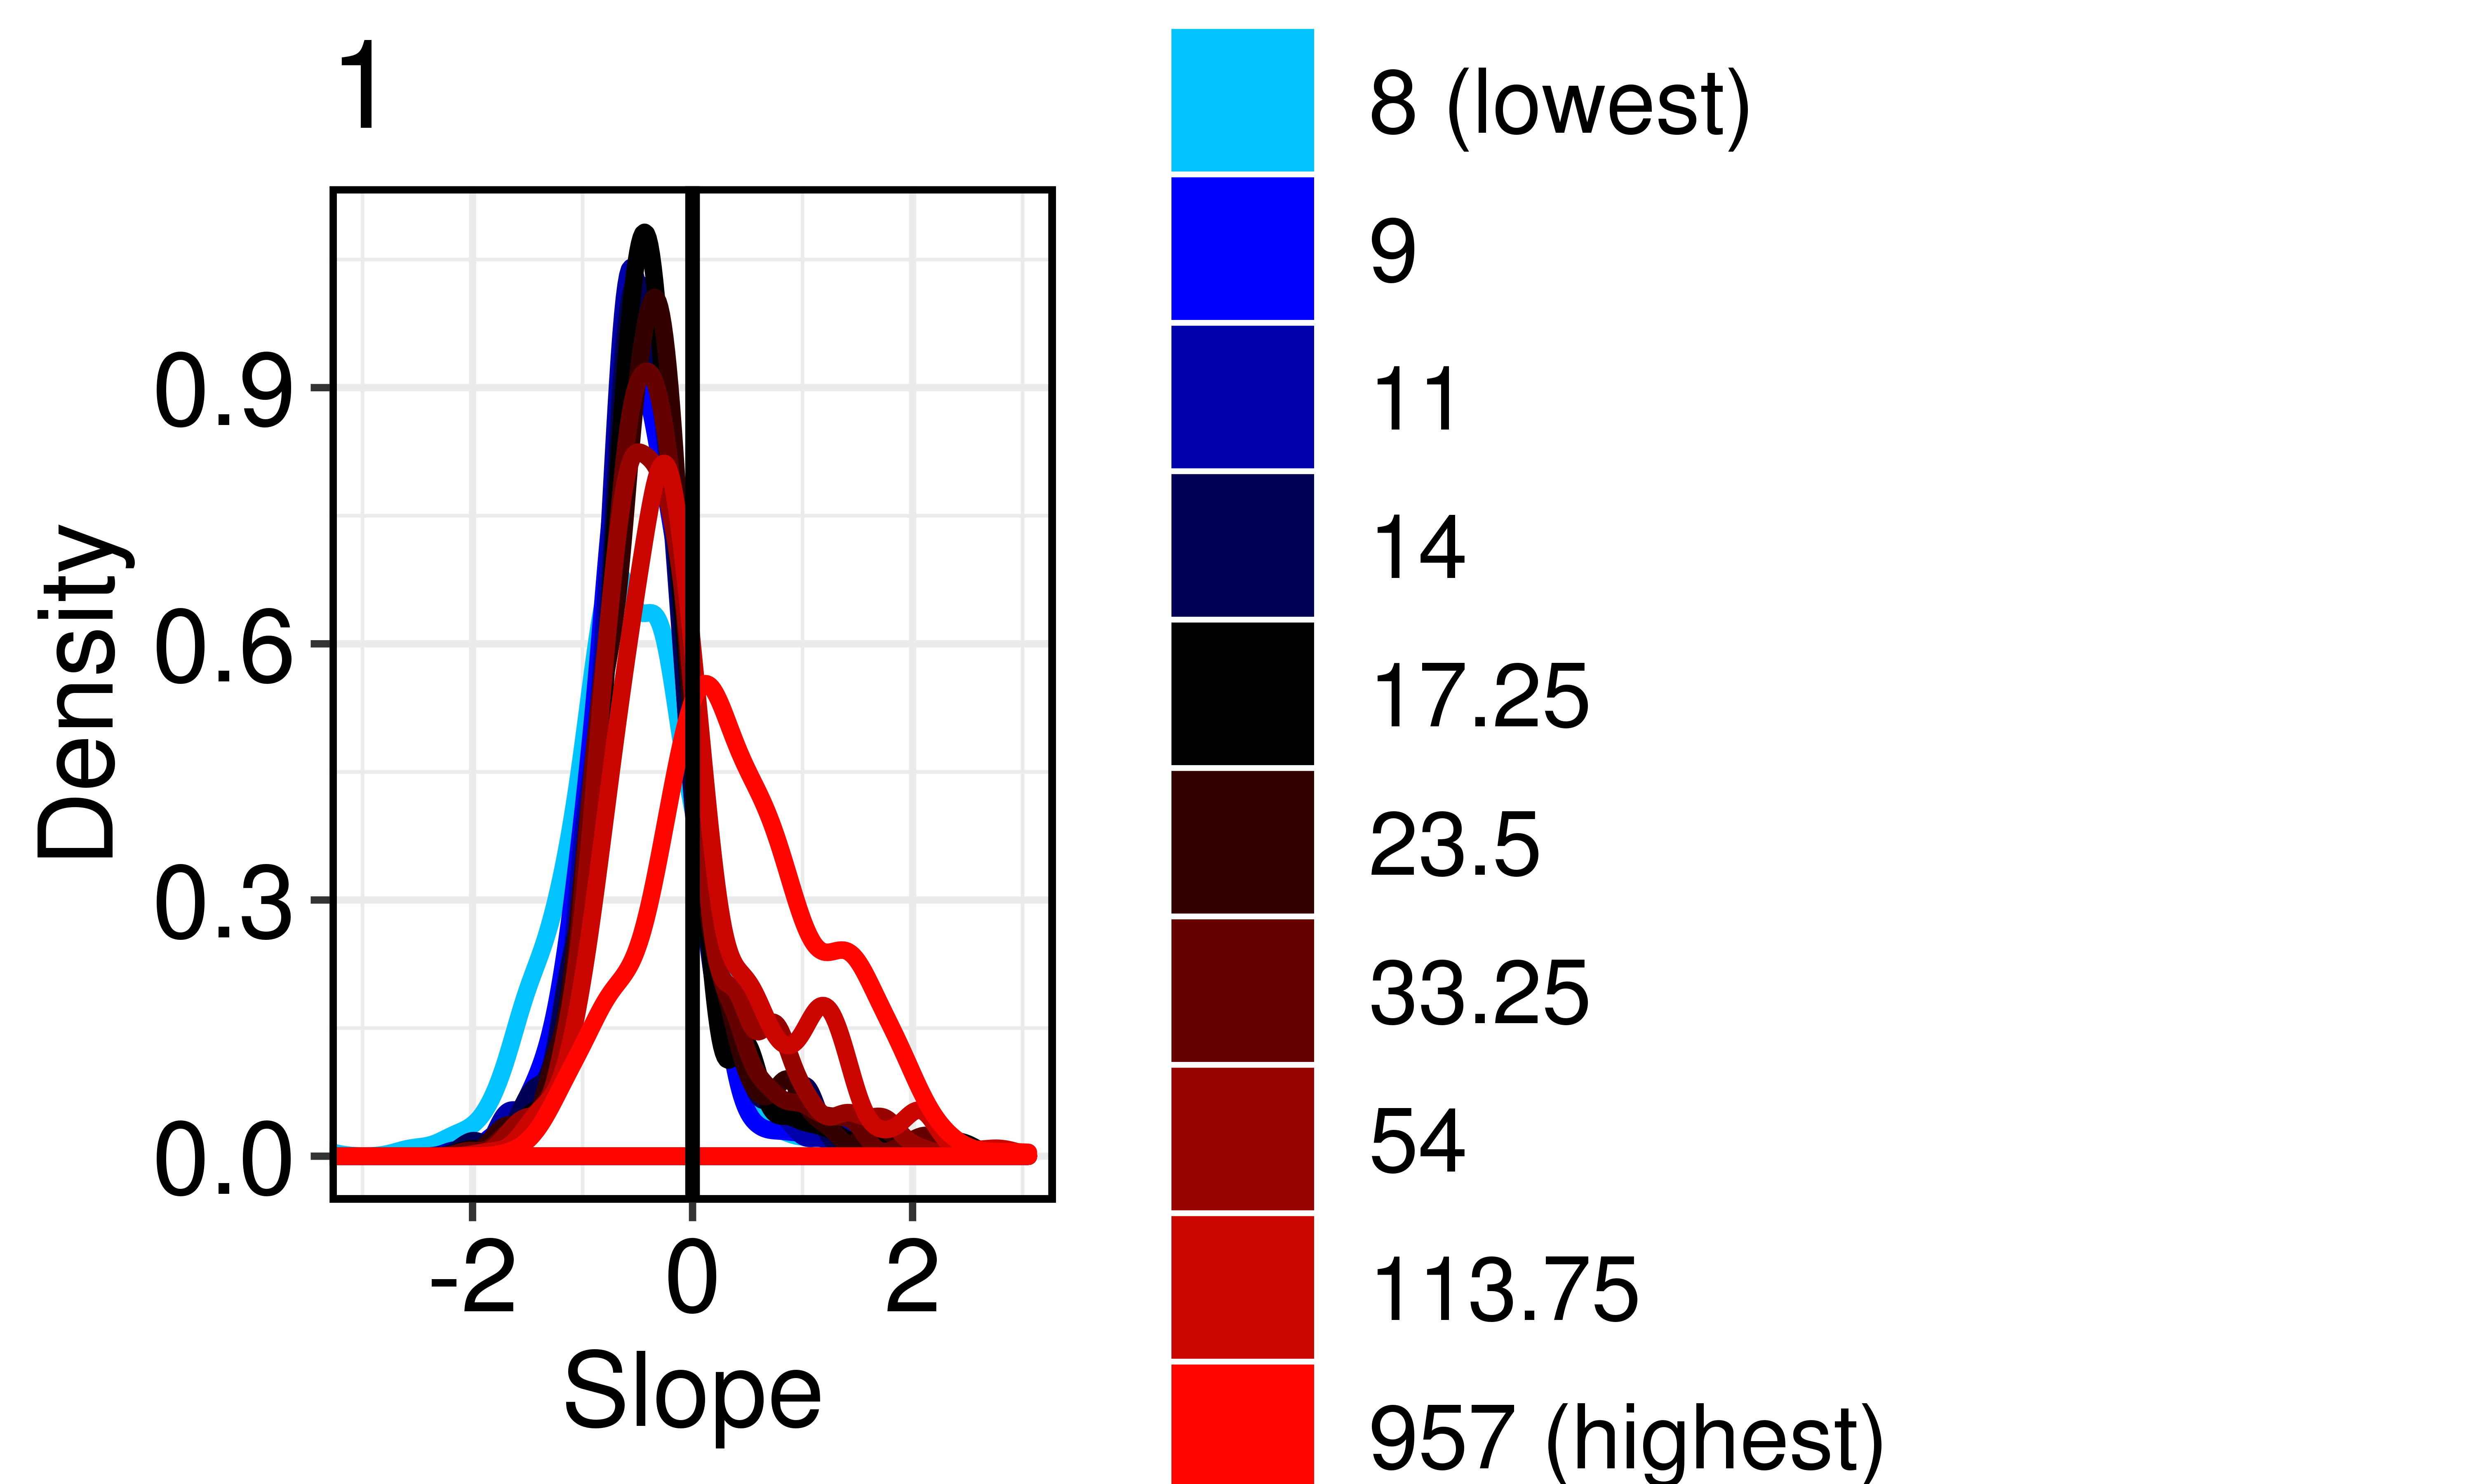

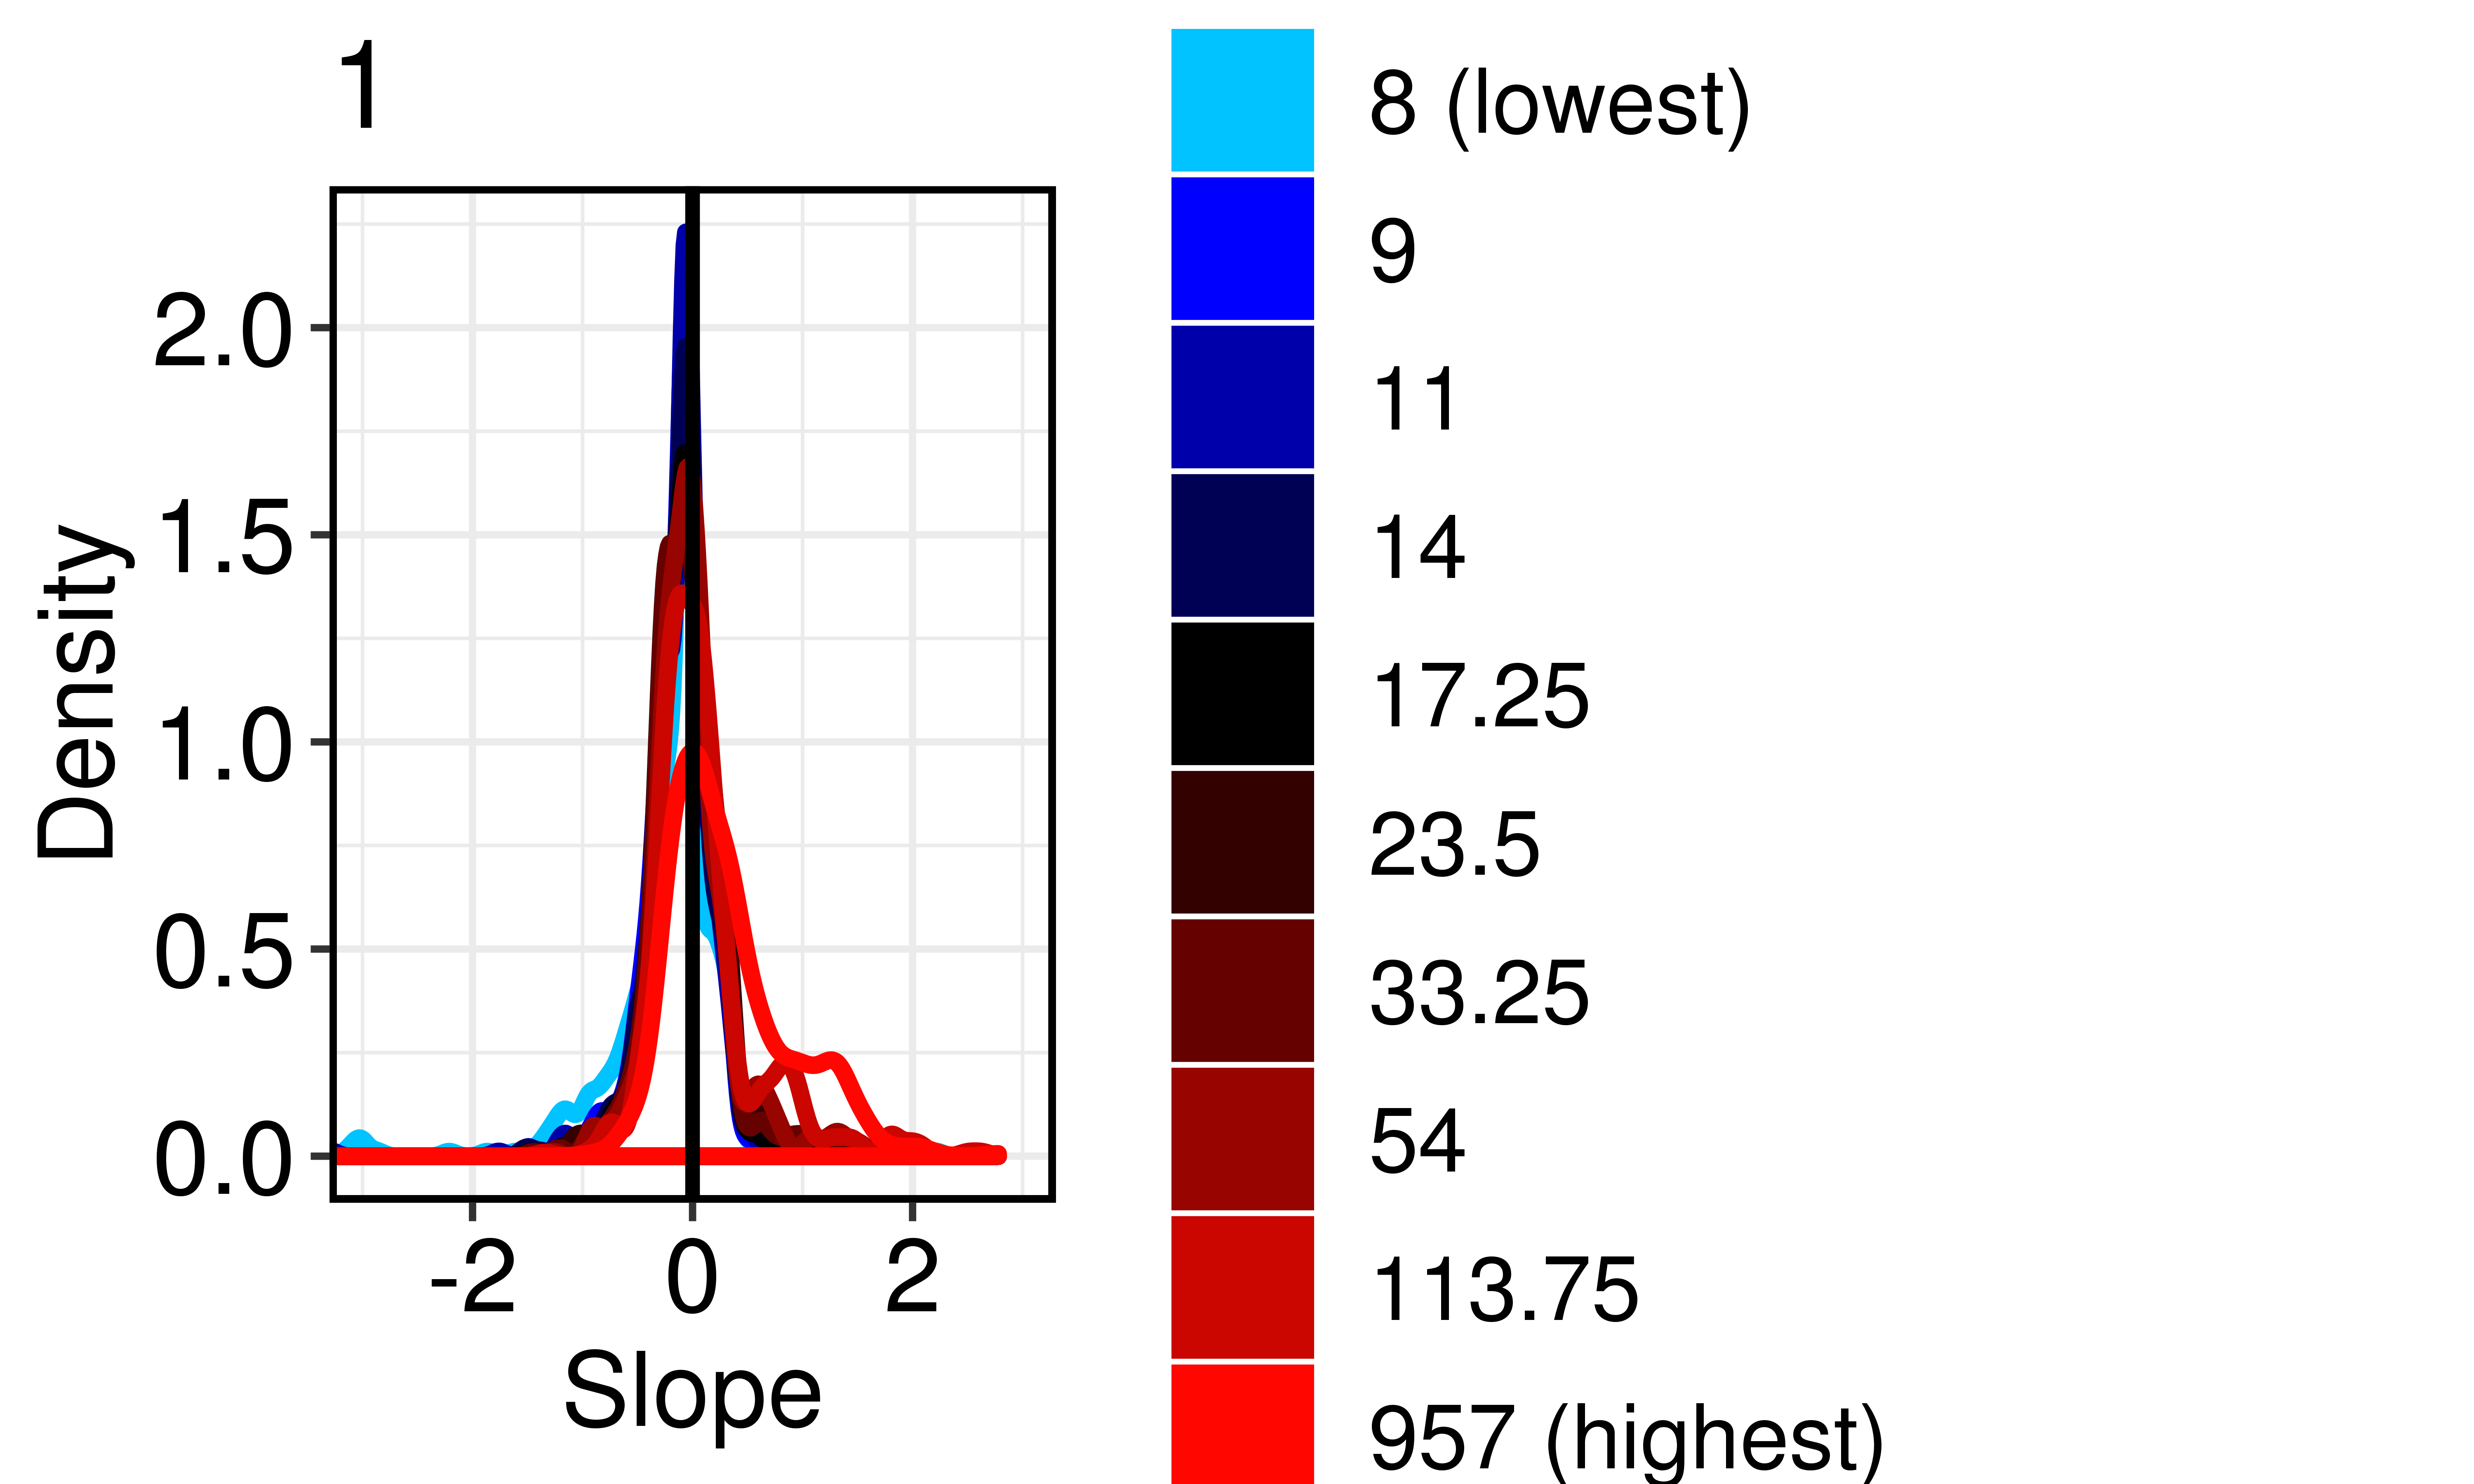

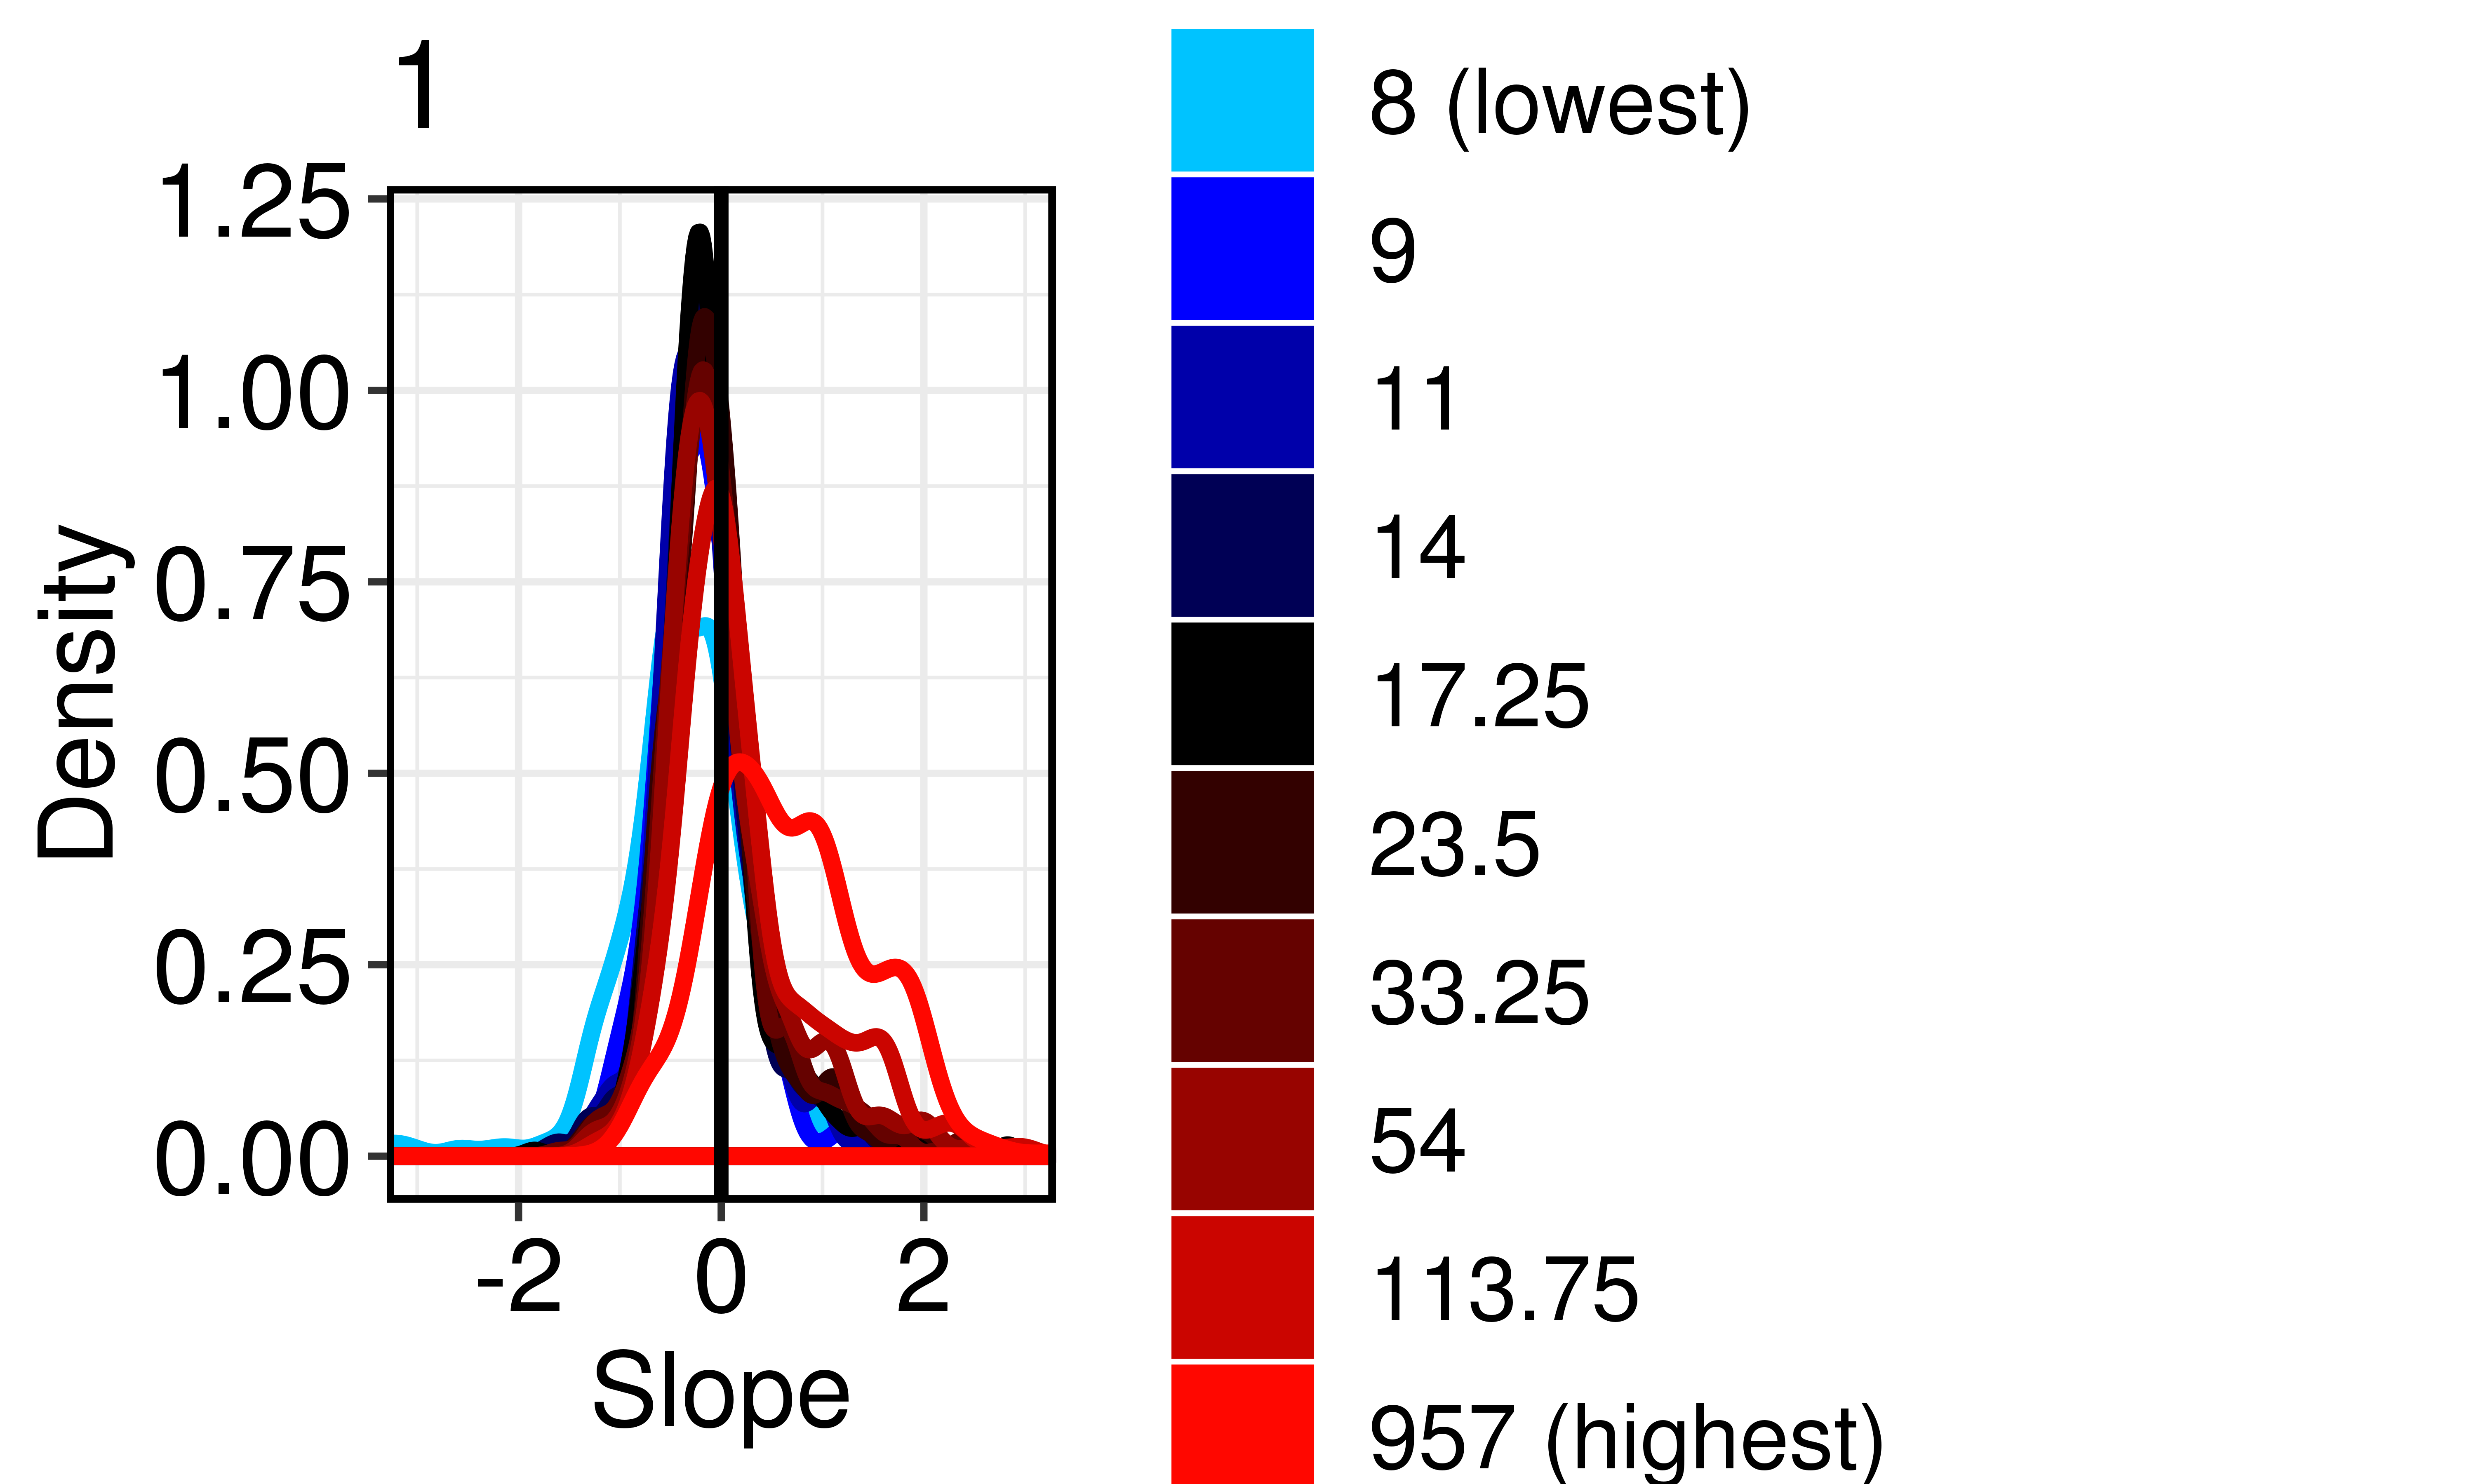

In [23]:
count_depth_norm(file_path=file_path)

## RLE

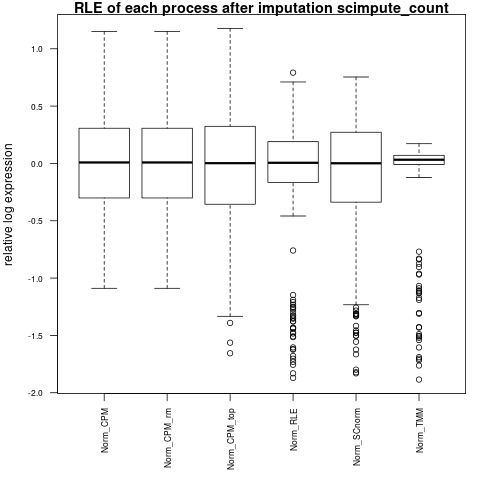

In [16]:
%%R
RLE_plot(file_path=file_path,impute_method="scimpute_count")

## cv density

lack of miRNA, leading to no refer line

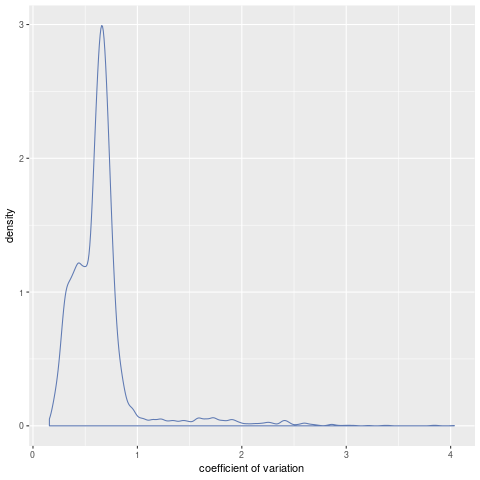

In [17]:
%%R
plot_cv_density(cv_mat_path=cv_mat_path,refer_gene_id_path=refer_gene_id_path)

## anno variables contribute variance plot

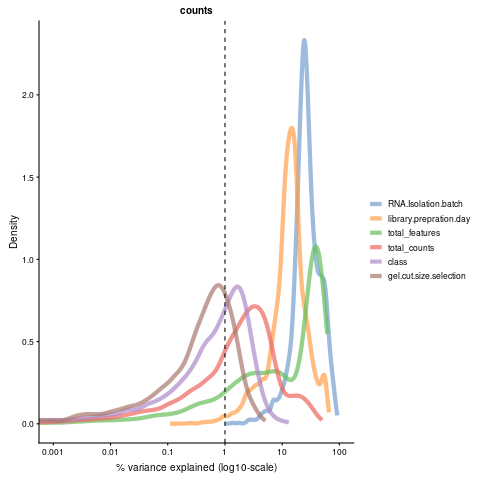

In [18]:
%%R
anno_contri_var(mat_path=cv_mat_path,batchinfo_path=batchinfo_path,classinfo_path=classinfo_path)

# notes


## done
- [x] main plot function
- [x] plot_highest_exprs y_axis names shortened
- [x] R2python
- [x] RLE more common

## to do
- [] pic enlarge
- [] RLE plot of RLE_norm
- [] polish pics
    - [] RLE referring to [source code](https://rdrr.io/bioc/scater/src/R/plotRLE.R)
    - [] count_depth pics par

In [201]:
!pwd

/home/xieyufeng/exSeek
